## Import Libraries, Data

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [146]:
RCMIP = pd.read_csv('RCMIP_ModelOutputs/RCMIP_combined.csv', low_memory=False)
print(f"Shape of RCMIP: {RCMIP.shape}")

FeliX = pd.read_csv('Vensim_Runs/FeliX_Outputs_Conc_Forc.csv', low_memory=False)
print(f"Shape of FeliX: {FeliX.shape}")


# --- Harmonize year columns between RCMIP and FeliX ---
# Find columns in FeliX that are years with .0 (e.g., '2100.0') and convert to string int (e.g., '2100')
felix_year_cols = [col for col in FeliX.columns if (
    isinstance(col, str) and col.replace('.0', '').isdigit() and col.endswith('.0')
)]
# Create a mapping from '2100.0' -> '2100'
felix_col_rename = {col: col.replace('.0', '') for col in felix_year_cols}
FeliX = FeliX.rename(columns=felix_col_rename)

# Optionally, do the same for RCMIP if it has float year columns (e.g., 2100.0)
rcmip_year_cols = [col for col in RCMIP.columns if (
    (isinstance(col, float) or (isinstance(col, str) and col.replace('.', '', 1).isdigit()))
    and str(col).endswith('.0')
)]
rcmip_col_rename = {col: str(int(float(col))) for col in rcmip_year_cols}
RCMIP = RCMIP.rename(columns=rcmip_col_rename)

print("\nRCMIP dtypes:")
print(RCMIP.dtypes)
print("\nFeliX dtypes:")
print(FeliX.dtypes)

Shape of RCMIP: (23444, 757)
Shape of FeliX: (132, 207)

RCMIP dtypes:
Model        object
Scenario     object
Region       object
Variable     object
Unit         object
             ...   
2496        float64
2497        float64
2498        float64
2499        float64
2500        float64
Length: 757, dtype: object

FeliX dtypes:
Model        object
Scenario     object
Region       object
Variable     object
Unit         object
             ...   
2096        float64
2097        float64
2098        float64
2099        float64
2100        float64
Length: 207, dtype: object


### Fix FeliX Dataset

In [147]:
#Standardize FeliX Units
FeliX['Unit'] = FeliX['Unit'].replace('W/(m*m)', 'W/m^2')

#Concat both files
merged_data = pd.concat([FeliX, RCMIP])
merged_data

Model Scenario Region  \
0              AIM    rcp60  World   
1              AIM    rcp60  World   
2              AIM    rcp60  World   
3              AIM    rcp60  World   
4              AIM    rcp60  World   
...            ...      ...    ...   
23439  unspecified   ssp460  World   
23440  unspecified   ssp460  World   
23441  unspecified   ssp460  World   
23442  unspecified   ssp460  World   
23443  unspecified   ssp460  World   

                                                Variable   Unit  \
0                         Atmospheric Concentrations|CH4    ppb   
1                         Atmospheric Concentrations|CO2    ppm   
2                         Atmospheric Concentrations|N2O    ppb   
3          Effective Radiative Forcing|Anthropogenic|CH4  W/m^2   
4          Effective Radiative Forcing|Anthropogenic|CO2  W/m^2   
...                                                  ...    ...   
23439  Effective Radiative Forcing|Natural|Volcanic|5...  W/m^2   
23440  Effective Radiative Forcing|Natural|Volcanic|6...  W/m^2   
23441  Effective Radiative Forcing|Natural|Volcanic|8...  W/m^2   
23442  Effective Radiative Forcing|Natural|Volcanic|9...  W/m^2   
23443  Effective Radiative Forcing|Natural|Volcanic|9...  W/m^2   

           ClimateModel        1900        1901        1902        1903  ...  \
0                 FeliX  808.000000  764.155894  725.322961  690.970734  ...   
1                 FeliX  284.700000  285.051677  285.526229  286.014523  ...   
2                 FeliX  273.200000  270.853880  268.527911  266.221922  ...   
3                 FeliX    0.056041    0.024350   -0.004594   -0.030941  ...   
4                 FeliX    0.140271    0.146726    0.155423    0.164359  ...   
...                 ...         ...         ...         ...         ...  ...   
23439  WASP,2,PROB-ECS3   -0.031799   -0.015959   -0.455772   -1.332510  ...   
23440  WASP,2,PROB-ECS3   -0.031404   -0.015760   -0.450101   -1.315927  ...   
23441  WASP,2,PROB-ECS3   -0.030965   -0.015540   -0.443809   -1.297529  ...   
23442  WASP,2,PROB-ECS3   -0.030606   -0.015360   -0.438665   -1.282492  ...   
23443  WASP,2,PROB-ECS3   -0.030329   -0.015221   -0.434700   -1.270906  ...   

       2491  2492  2493  2494  2495  2496  2497  2498  2499  2500  
0       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
23439   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
23440   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
23441   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
23442   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
23443   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[23576 rows x 757 columns]

In [148]:
unique_scenarios = FeliX['Scenario'].unique()
print(f"Unique Scenarios: {unique_scenarios}")

Unique Scenarios: ['rcp60' 'ssp370' 'ssp370-lowNTCF-aerchemmip' 'ssp370-lowNTCF-gidden'
 'historical' 'ssp434' 'ssp460' 'rcp26' 'ssp119' 'ssp126' 'rcp85' 'ssp245'
 'rcp45' 'ssp534-over' 'ssp585' 'esm-bell-1000PgC' 'esm-bell-2000PgC'
 'esm-bell-750PgC' 'esm-pi-CO2pulse' 'esm-pi-cdr-pulse' 'esm-piControl'
 'historical-cmip5']


## Check RCMIP Data

In [154]:
def visualize_rcmip_data(df, 
                         variables=None, 
                         scenarios=None, 
                         year_range=(1900, 2100),
                         region='World',
                         exclude_models=None,
                         exclude_scenarios=None,
                         compare_by='ClimateModel+Scenario',
                         plot_title=None,
                         figsize=(12, 6)):
    """
    Visualize RCMIP data with customizable parameters.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The RCMIP DataFrame
    variables : list or str, optional
        List of variables to include, or single variable string. 
        If None, includes all variables
    scenarios : list or str, optional
        List of scenarios to include, or single scenario string.
        If None, includes all scenarios
    year_range : tuple, optional
        (start_year, end_year) for filtering data. Default (1900, 2100)
    region : str, optional
        Region to filter by. Default 'World'
    exclude_models : list, optional
        List of model names to exclude from visualization
    exclude_scenarios : list, optional
        List of scenario names to exclude from visualization
    compare_by : str, optional
        How to group data for comparison: 'ClimateModel', 'Scenario', or 'ClimateModel+Scenario'
    plot_title : str, optional
        Custom title for the plot. If None, auto-generated
    figsize : tuple, optional
        Figure size (width, height). Default (12, 6)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object of the plot
    df_filtered : pandas.DataFrame
        The filtered DataFrame used for plotting
    """
    
    print(f"Original data shape: {df.shape}")
    
    # Apply variable filter
    if variables is not None:
        if isinstance(variables, str):
            variables = [variables]
        df = df[df['Variable'].isin(variables)]
        print(f"After variable filtering: {df.shape}")
    
    # Apply scenario filter
    if scenarios is not None:
        if isinstance(scenarios, str):
            scenarios = [scenarios]
        df = df[df['Scenario'].isin(scenarios)]
        print(f"After scenario filtering: {df.shape}")
    
    # Apply region filter
    if region is not None:
        df = df[df['Region'] == region]
        print(f"After region filtering: {df.shape}")
    
    # Apply year range filter
    start_year, end_year = year_range
    year_columns = [str(year) for year in range(start_year, end_year + 1)]
    identifier_columns = ['ClimateModel', 'Scenario', 'Region', 'Variable', 'Unit']
    
    # Only keep columns that exist in the DataFrame
    columns_to_keep = [col for col in identifier_columns if col in df.columns] + \
                      [col for col in year_columns if col in df.columns]
    
    df = df[columns_to_keep]
    print(f"After year range filtering: {df.shape}")
    
    # Apply exclusion filters
    if exclude_models is not None:
        df = df[~df['ClimateModel'].isin(exclude_models)]
        print(f"After excluding models: {df.shape}")
    
    if exclude_scenarios is not None:
        df = df[~df['Scenario'].isin(exclude_scenarios)]
        print(f"After excluding scenarios: {df.shape}")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get year columns for plotting
    year_cols = [col for col in df.columns if col.isdigit()]
    years = [int(col) for col in year_cols]
    
    # Group by the specified comparison method
    if compare_by == 'ClimateModel+Scenario':
        df['ClimateModel+Scenario'] = df['ClimateModel'] + ' | ' + df['Scenario']
        group_col = 'ClimateModel+Scenario'
    else:
        group_col = compare_by
    
    # Plot each group
    offset = (years[-1] - years[0]) * 0.01
    colors = plt.cm.tab20(np.linspace(0, 1, len(df[group_col].unique())))
    
    for i, (key, grp) in enumerate(df.groupby(group_col)):
        y = grp[year_cols].values.squeeze()
        
        # Check if this group contains FeliX data
        is_felix = grp['ClimateModel'].iloc[0] == 'FeliX'
        
        # Set line properties based on whether it's FeliX
        if is_felix:
            linewidth = 3.0
            alpha = 1.0
            color = 'red'  # Highlight FeliX in red
        else:
            linewidth = 1.5
            alpha = 0.8
            color = colors[i % len(colors)]
        
        if y.ndim == 1:
            mask = ~pd.isna(y)
            if mask.any():
                ax.plot(np.array(years)[mask], y[mask], 
                        color=color, 
                        linewidth=linewidth, alpha=alpha)
                last_valid_idx = np.where(mask)[0][-1]
                ax.text(years[last_valid_idx] + offset, y[last_valid_idx], 
                        str(key), fontsize=8, va='center',
                        weight='bold' if is_felix else 'normal')
        else:
            for row in y:
                mask = ~pd.isna(row)
                if mask.any():
                    ax.plot(np.array(years)[mask], row[mask], 
                            color=color, 
                            linewidth=linewidth, alpha=alpha)
                    last_valid_idx = np.where(mask)[0][-1]
                    ax.text(years[last_valid_idx] + offset, row[last_valid_idx], 
                            str(key), fontsize=8, va='center',
                            weight='bold' if is_felix else 'normal')
    
    # Customize the plot
    ax.set_xlabel('Year', fontsize=12)
    
    # Get variable name for y-label
    if variables is not None and len(variables) == 1:
        ylabel = variables[0]
    else:
        ylabel = "Variable Value"
    
    # Add unit if available
    if 'Unit' in df.columns and not df['Unit'].empty:
        unit = df['Unit'].iloc[0]
        ylabel += f" ({unit})"
    
    ax.set_ylabel(ylabel, fontsize=12)
    
    # Set title
    if plot_title is None:
        plot_title = f"RCMIP Data Visualization\n{compare_by} Comparison"
    ax.set_title(plot_title, fontsize=14, pad=20)
    
    # Add grid and remove spines
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, 
             color='lightgray', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Extend x-axis for labels
    ax.set_xlim(years[0], years[-1] + 5 * offset)
    
    plt.tight_layout()
    plt.show()
    
    return fig, df

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


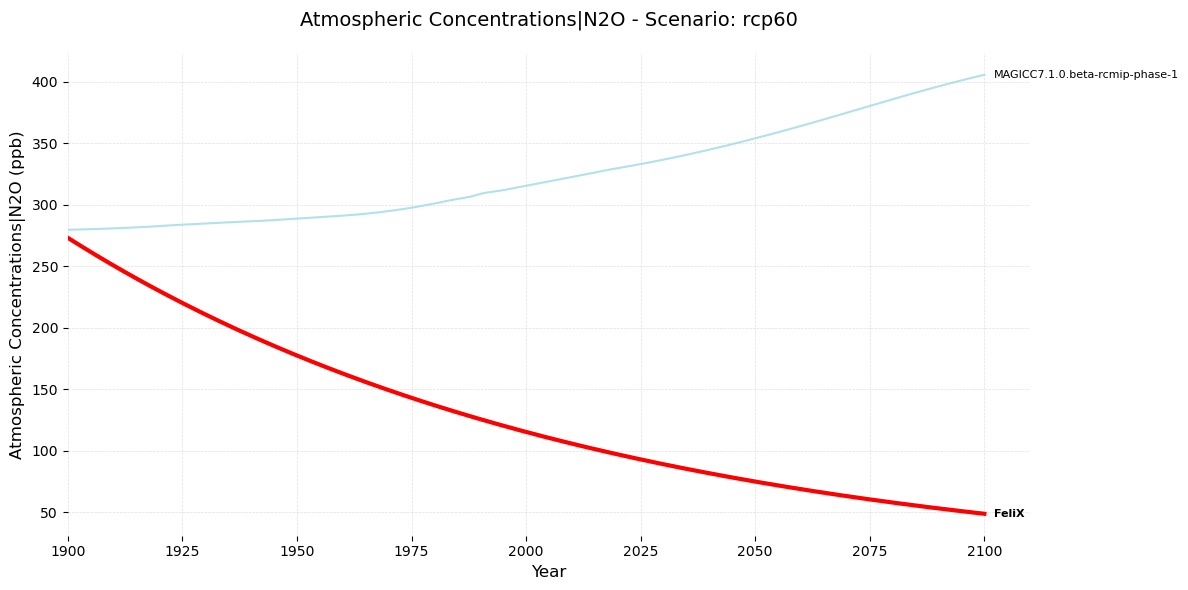

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


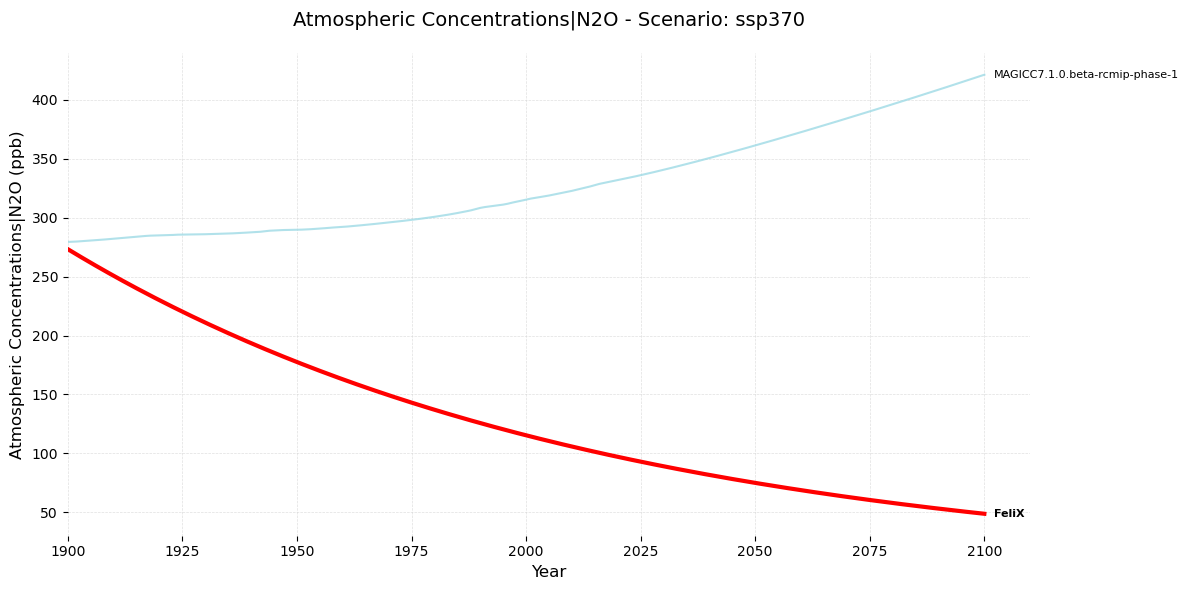

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


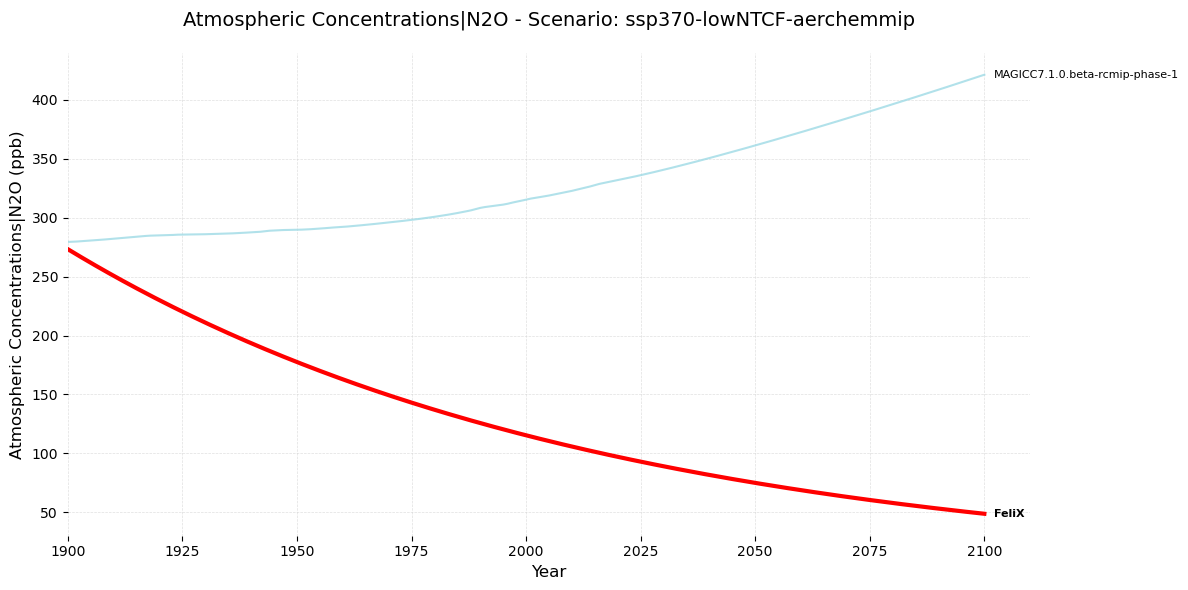

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


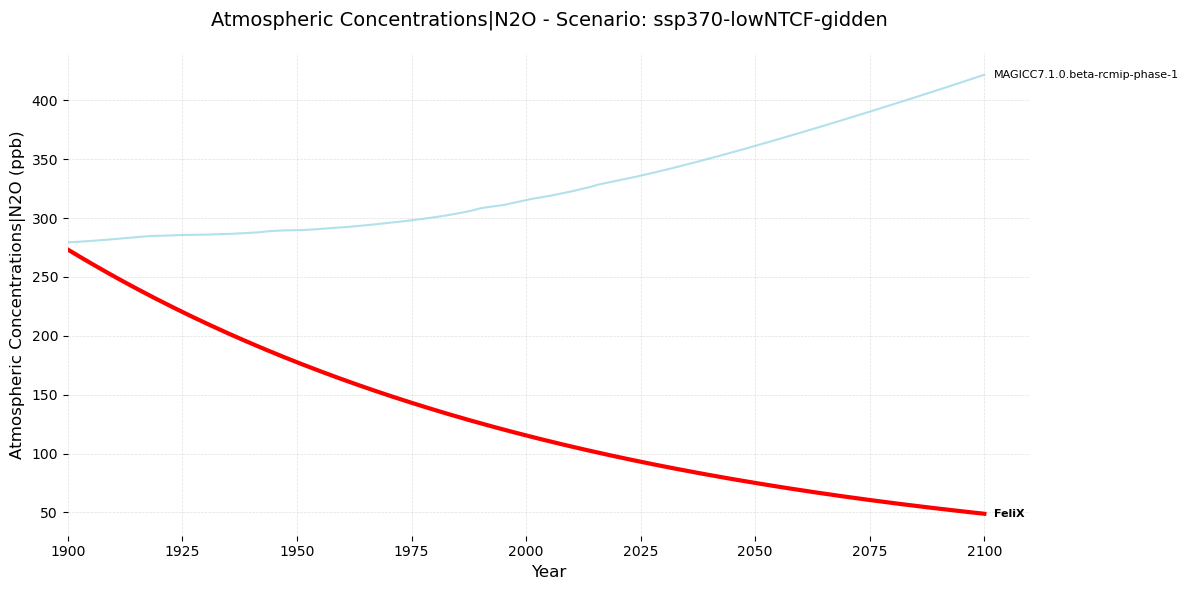

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


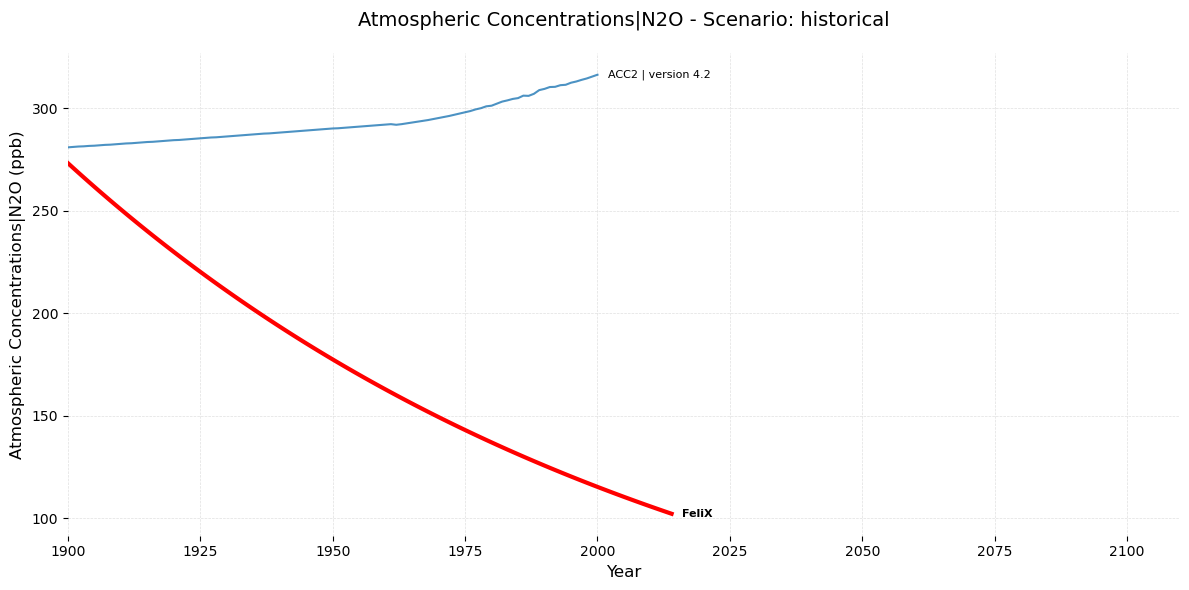

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


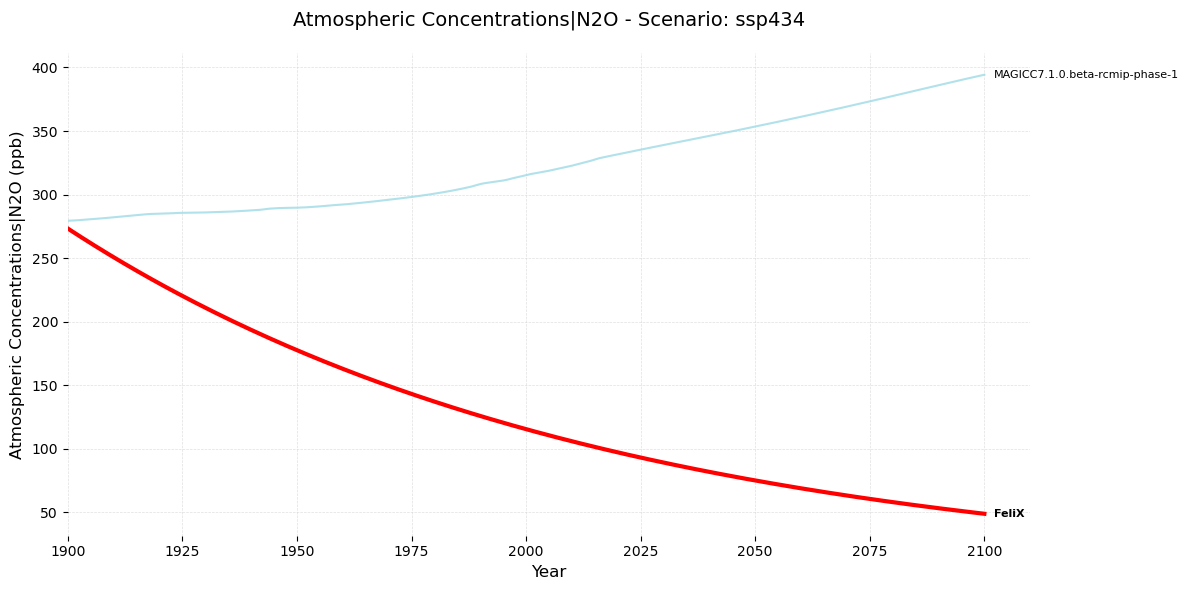

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


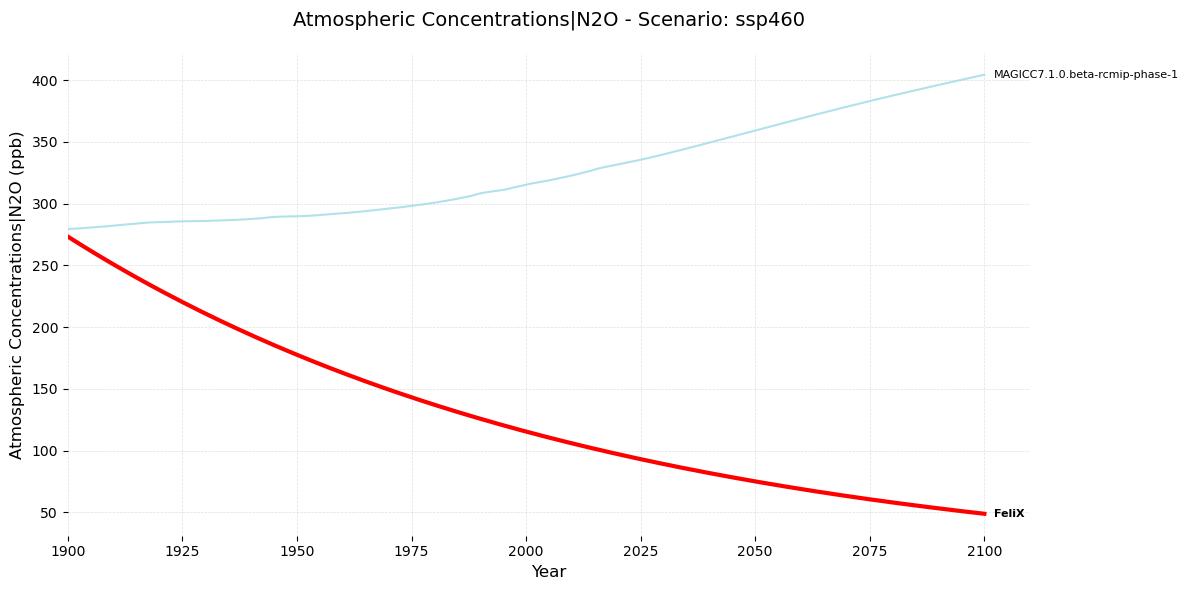

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


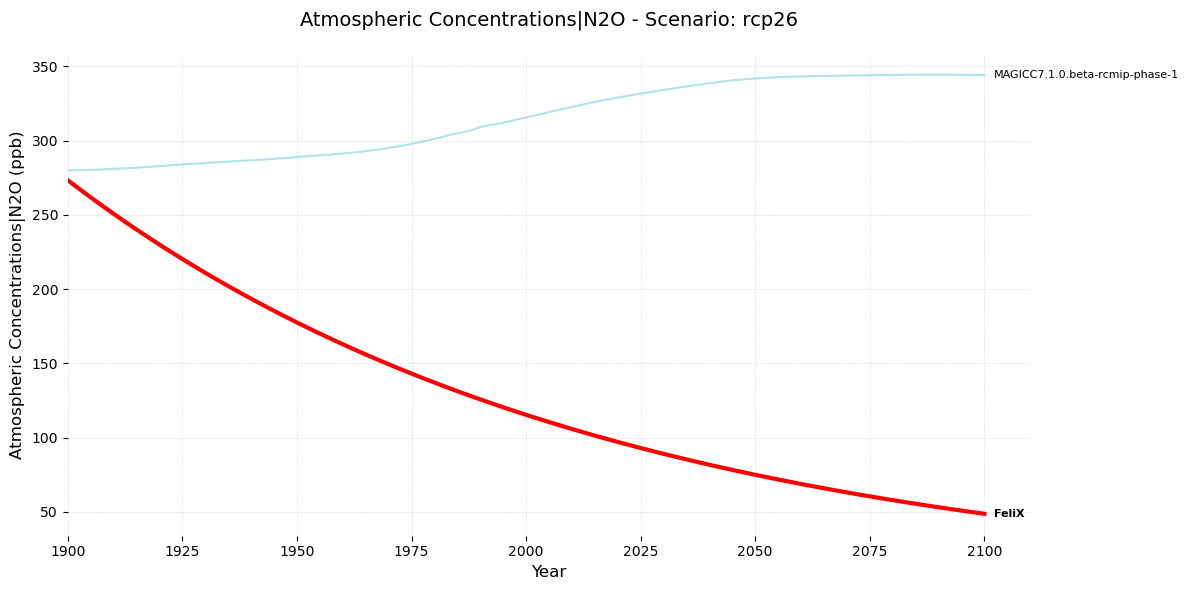

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


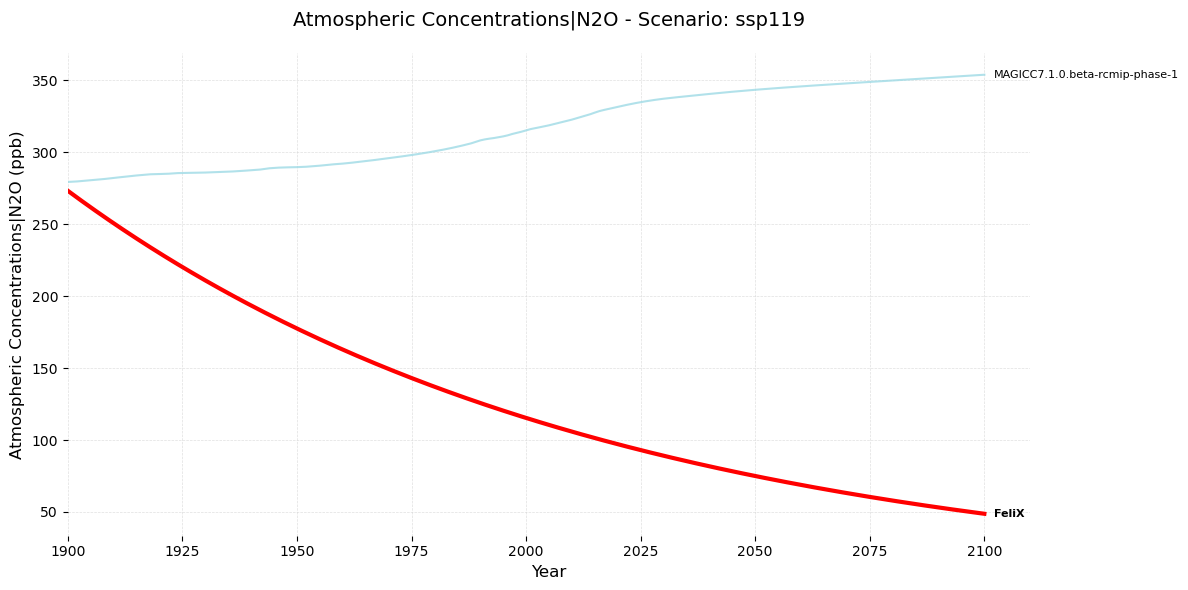

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


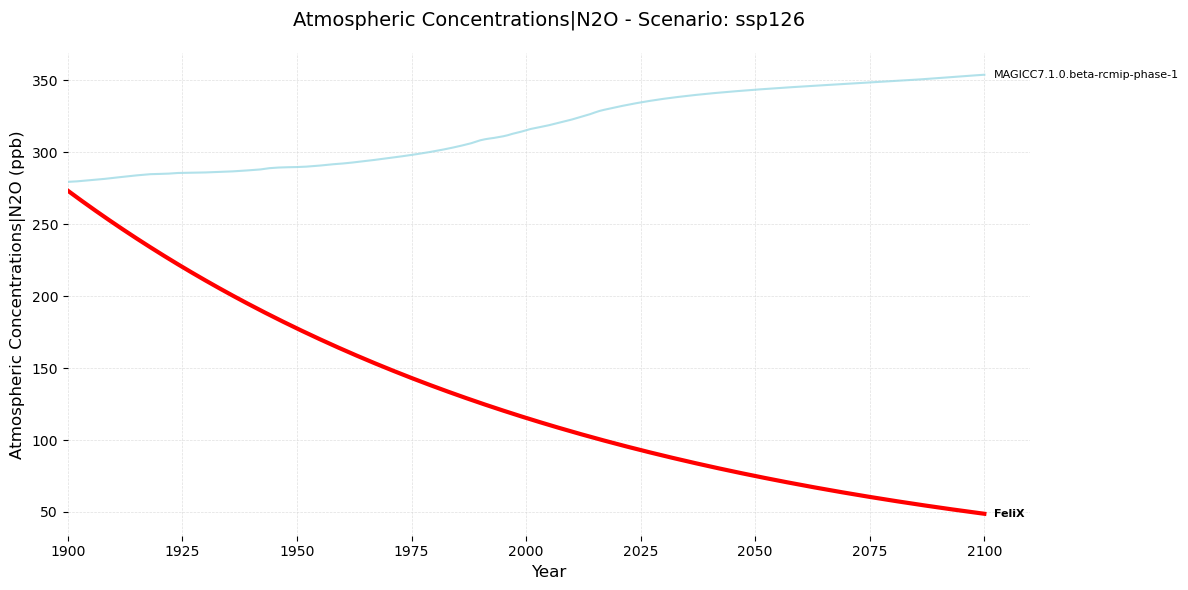

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


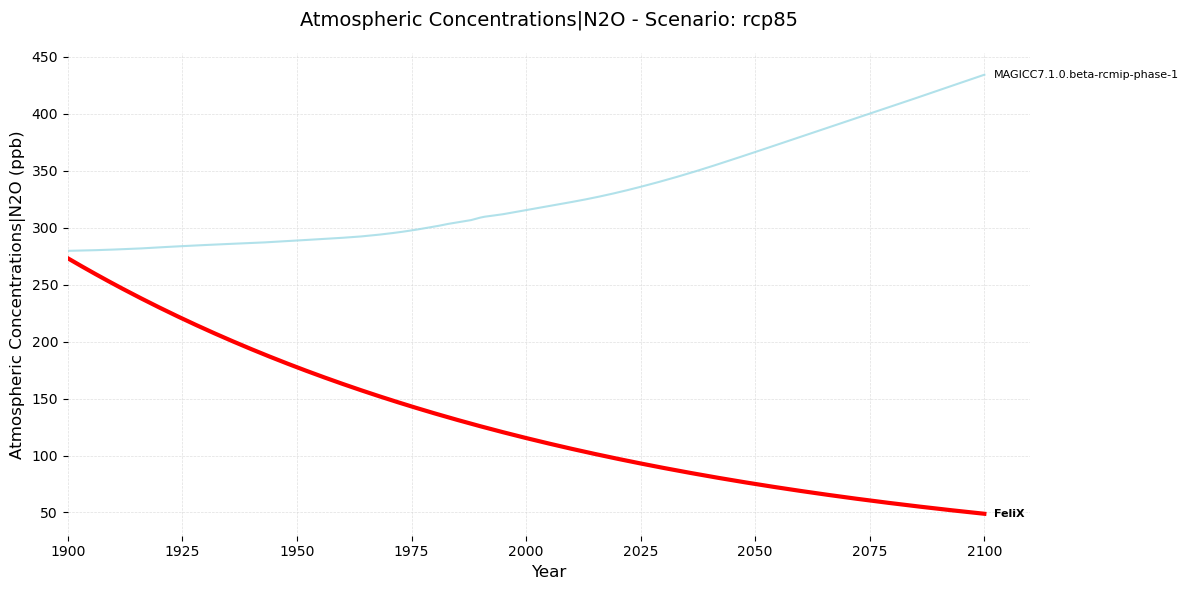

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


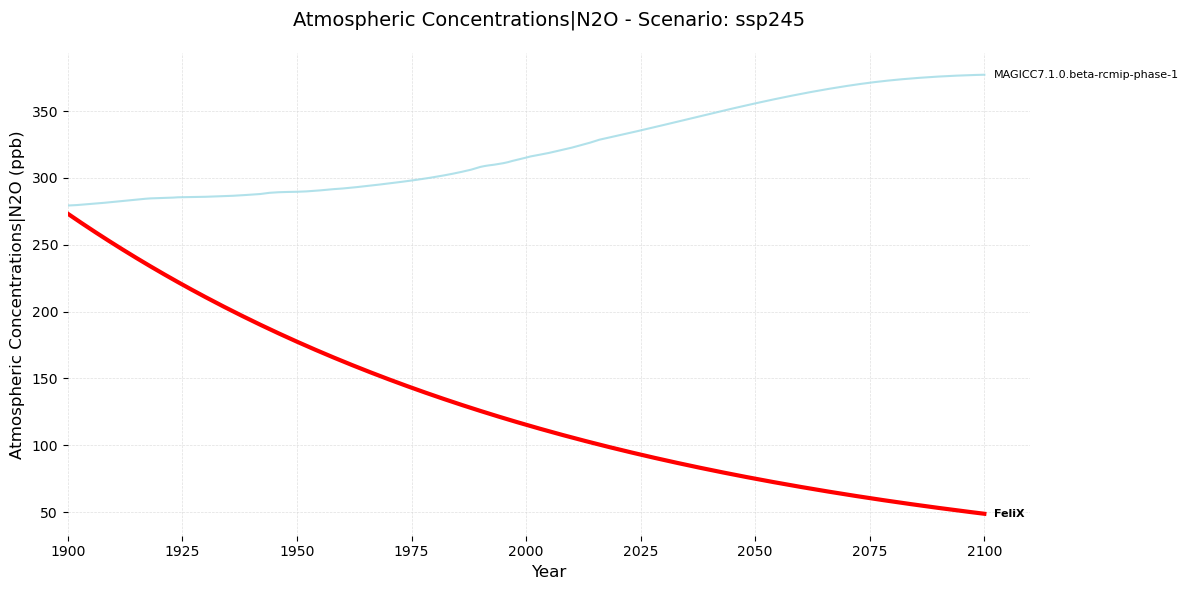

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


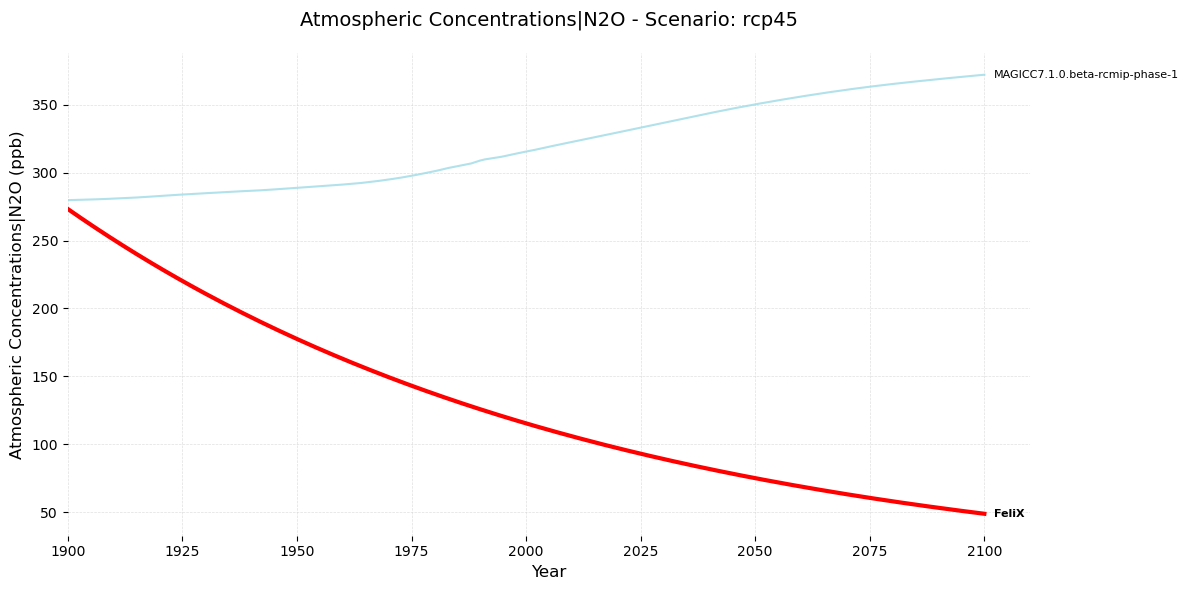

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


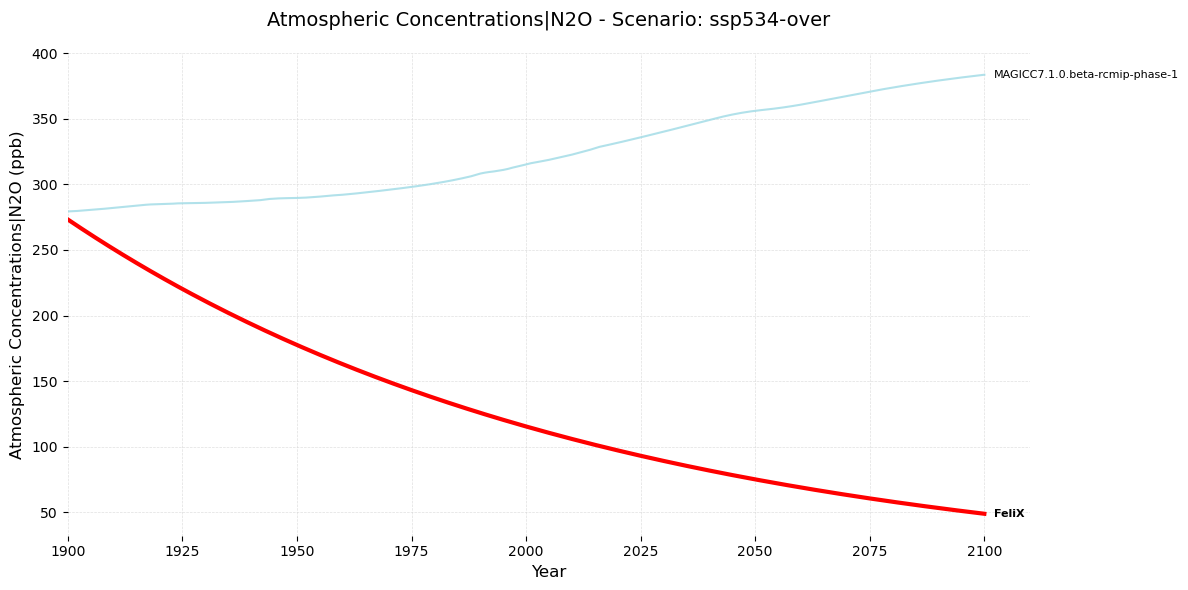

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


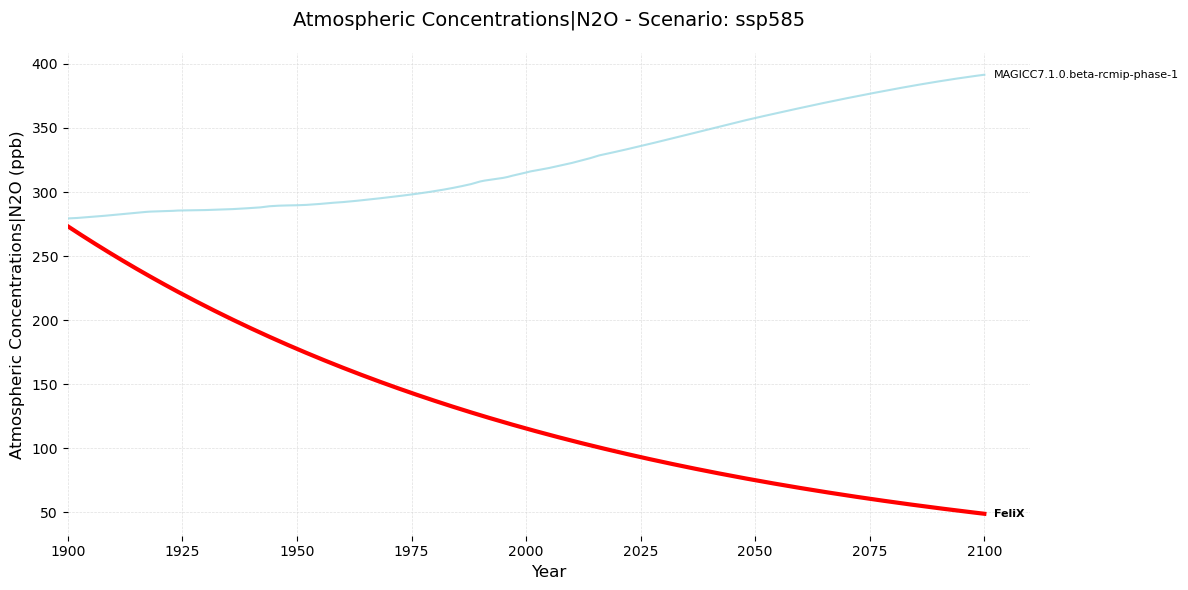

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


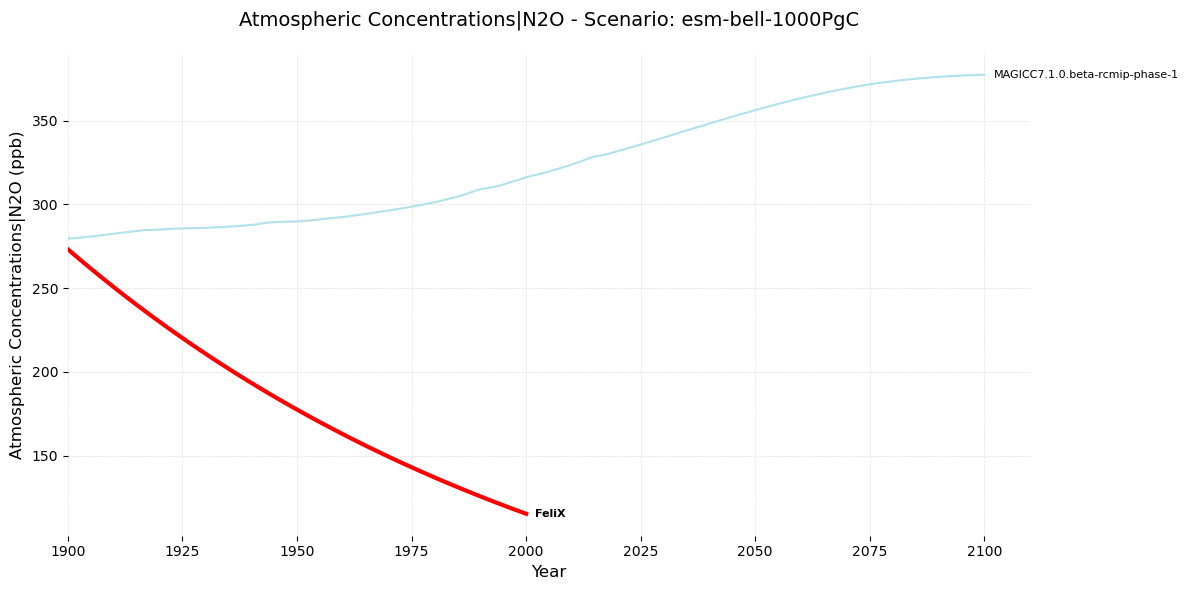

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


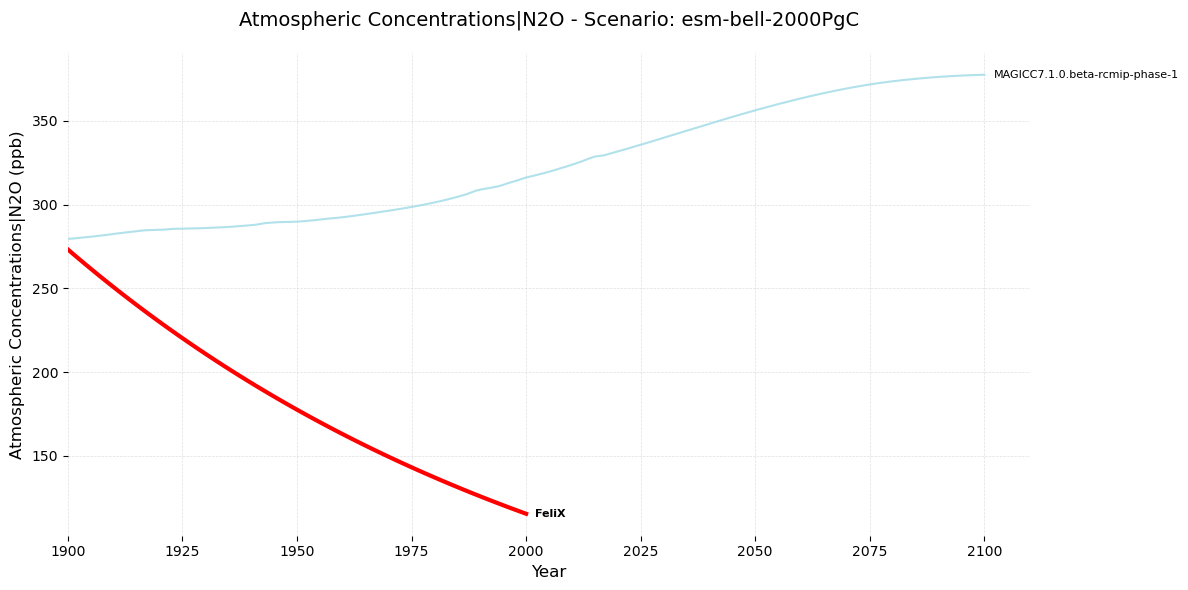

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


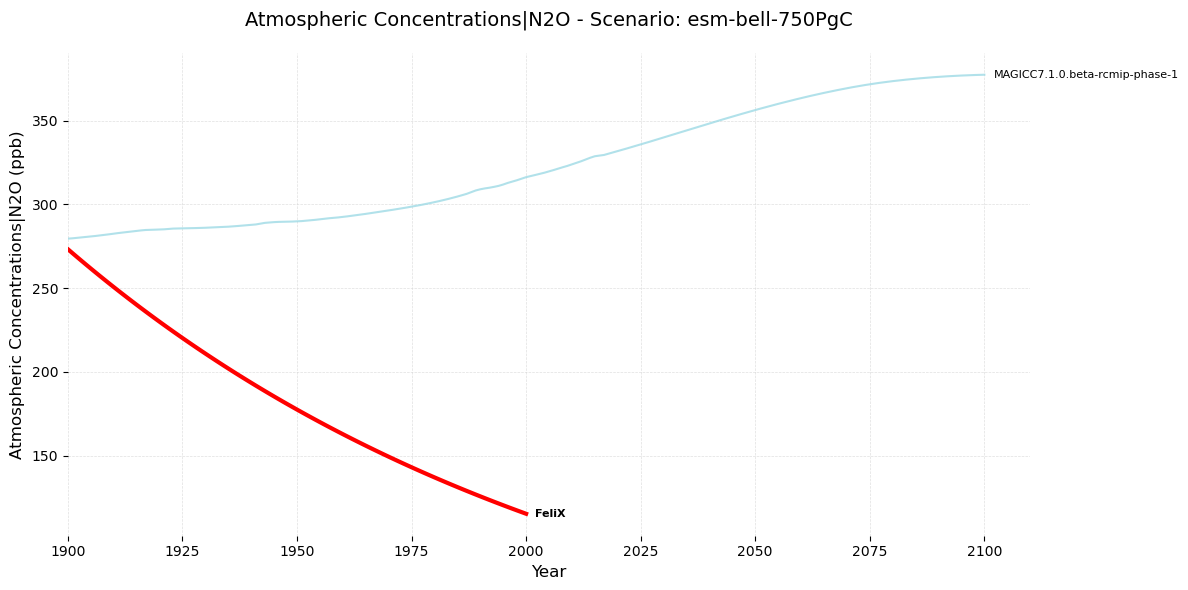

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


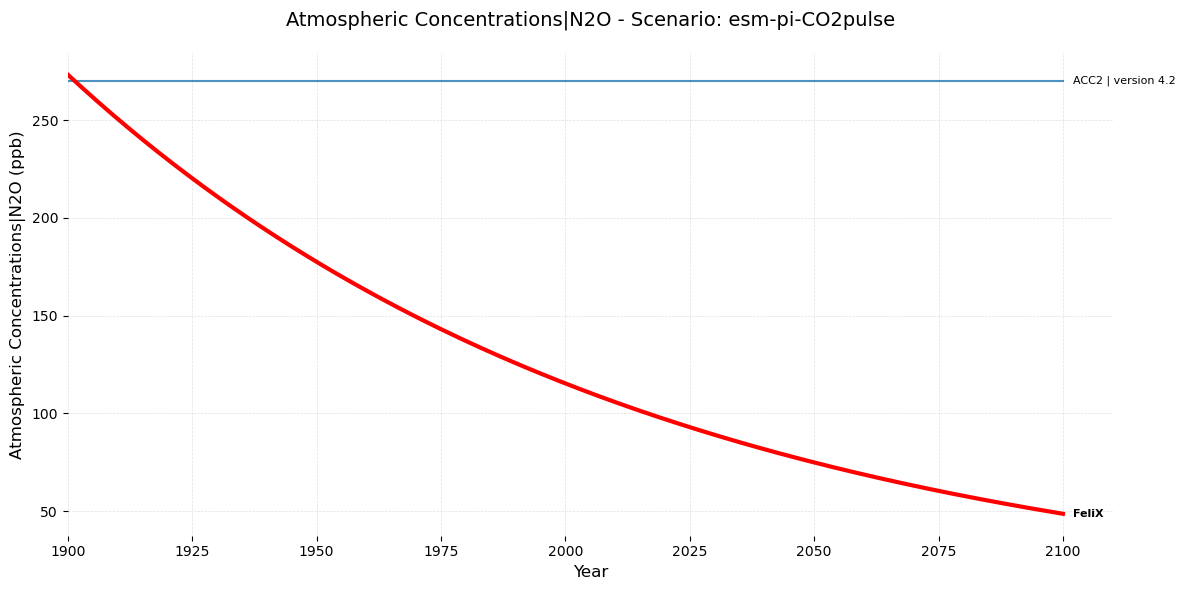

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


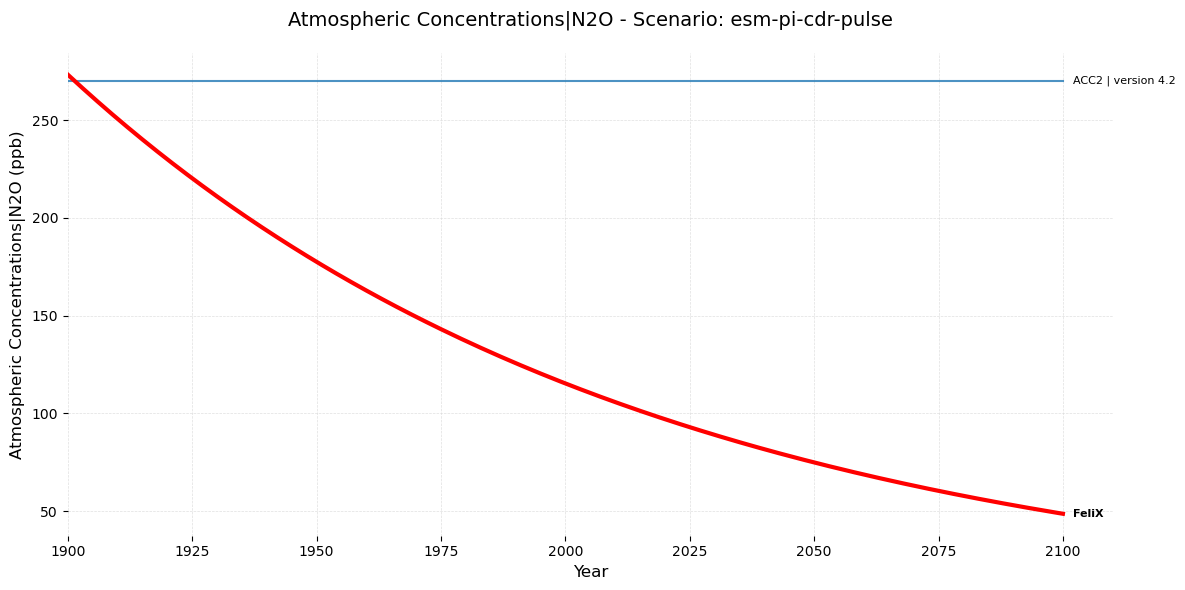

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (3, 757)
After region filtering: (3, 757)
After year range filtering: (3, 206)


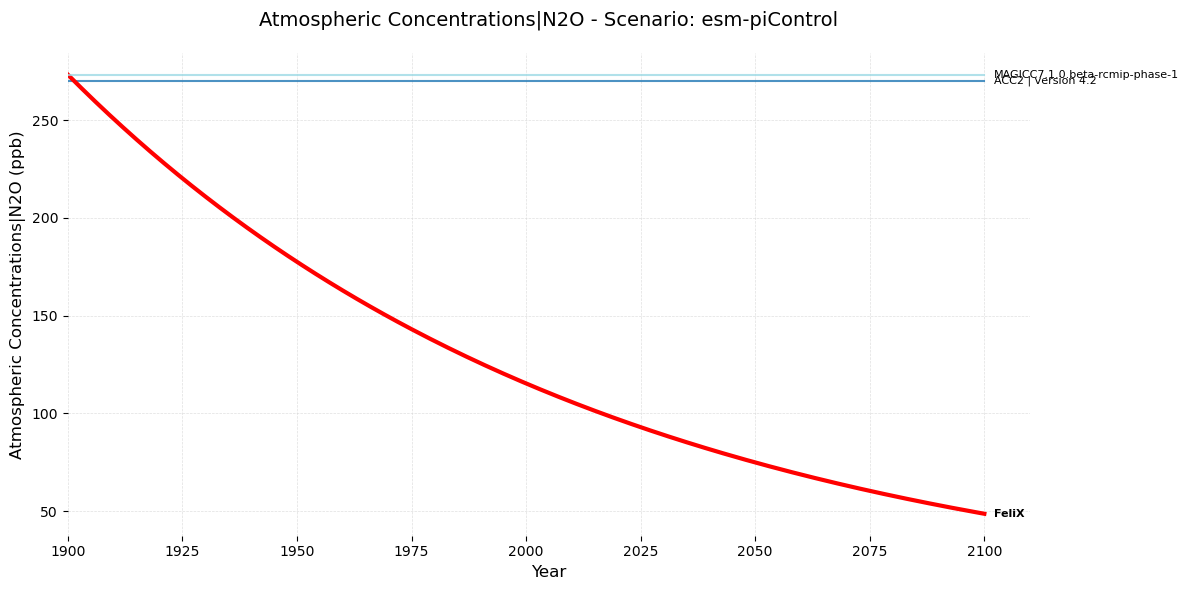

Original data shape: (23576, 757)
After variable filtering: (102, 757)
After scenario filtering: (1, 757)
After region filtering: (1, 757)
After year range filtering: (1, 206)


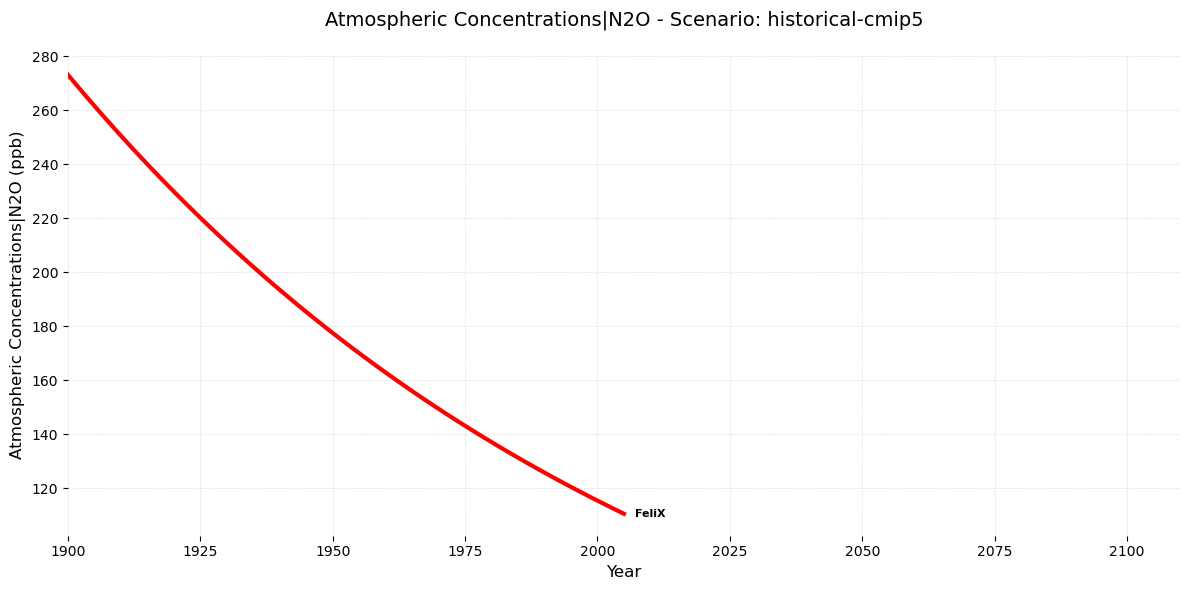

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (20, 757)
After region filtering: (20, 757)
After year range filtering: (20, 206)


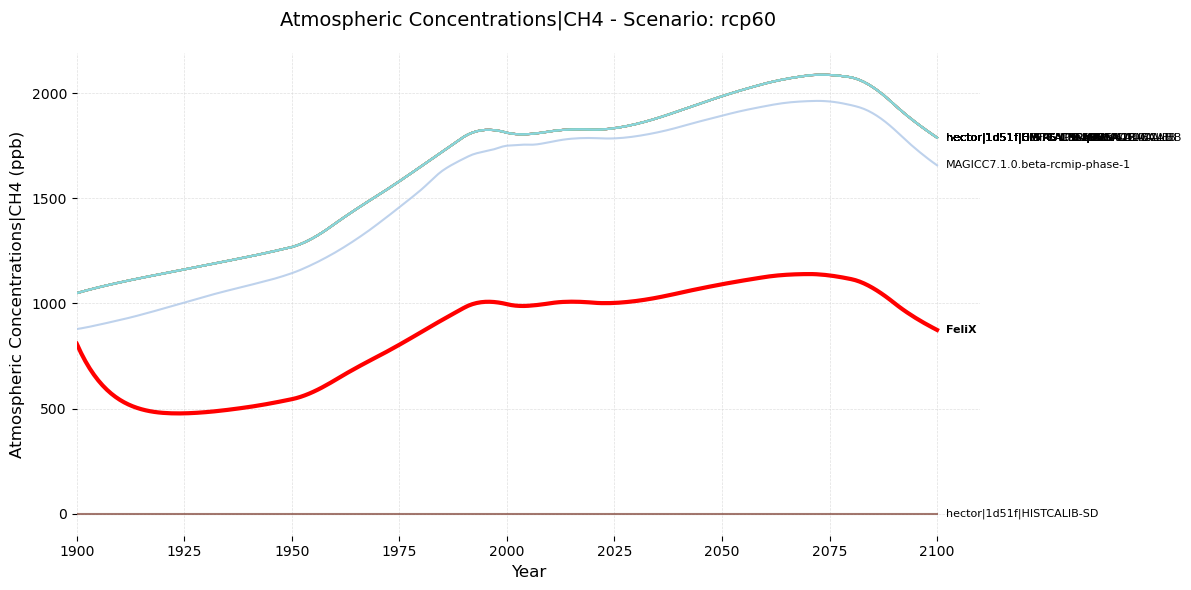

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (17, 757)
After region filtering: (17, 757)
After year range filtering: (17, 206)


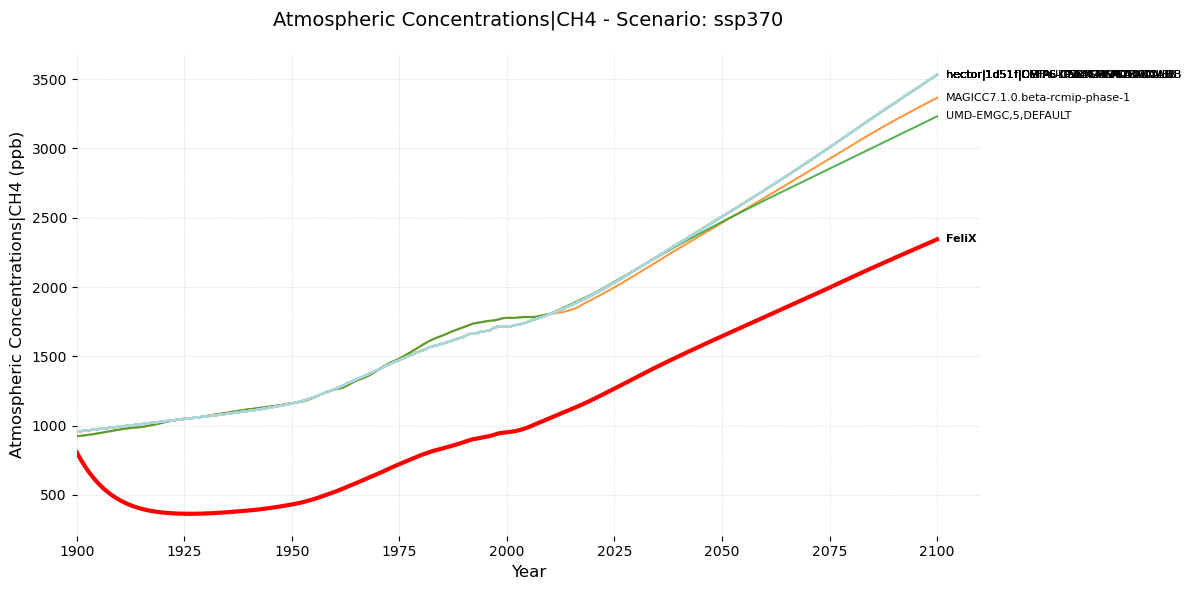

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


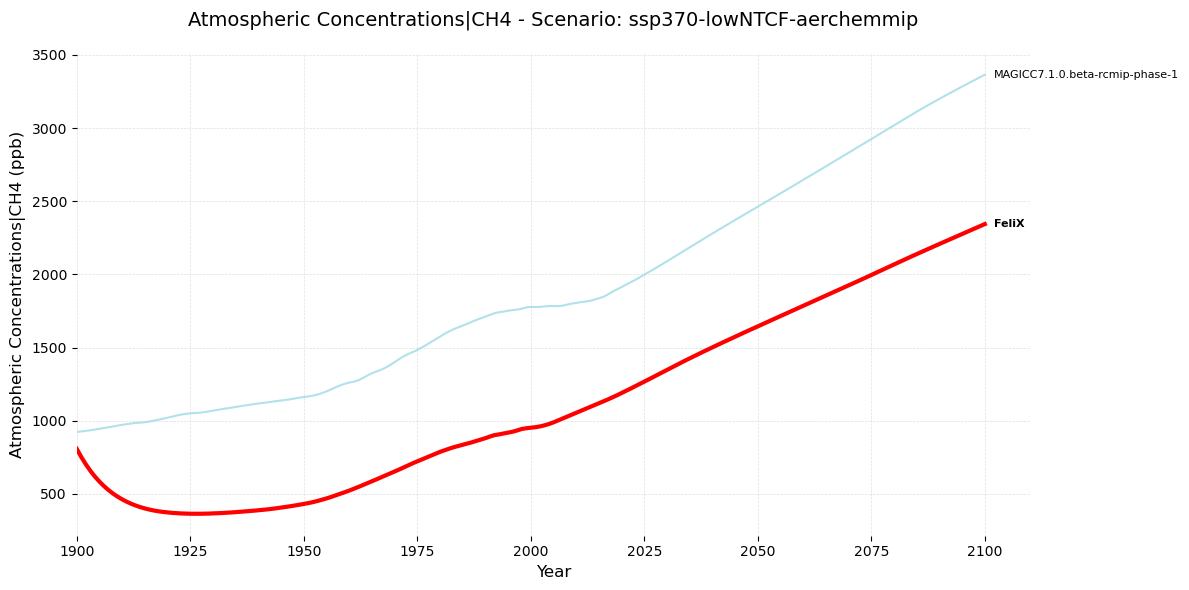

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


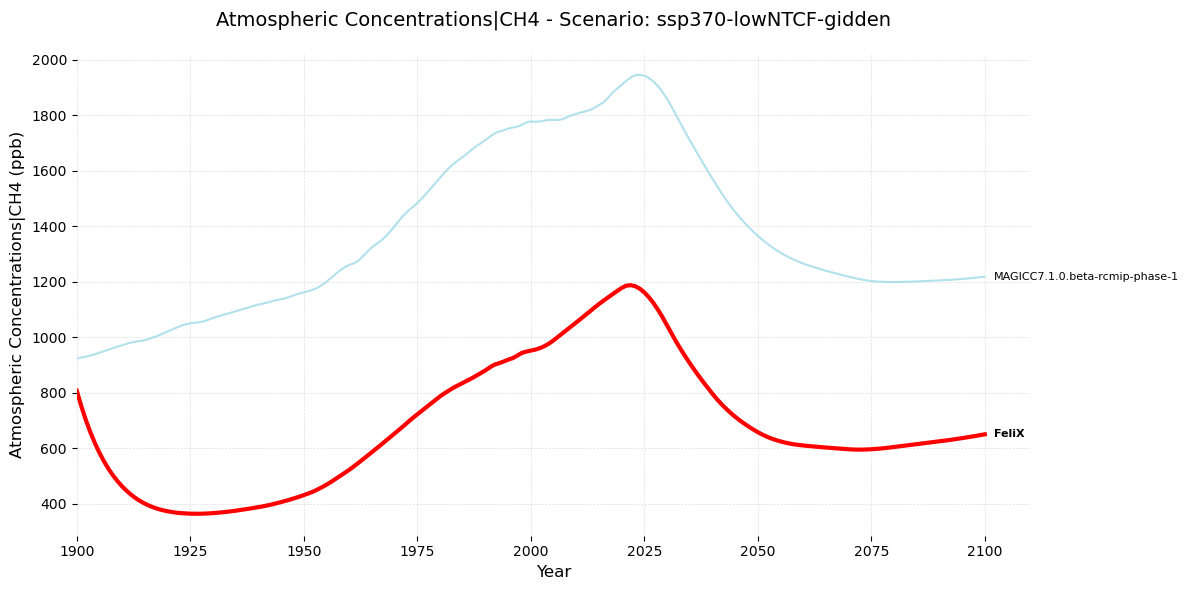

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (39, 757)
After region filtering: (39, 757)
After year range filtering: (39, 206)


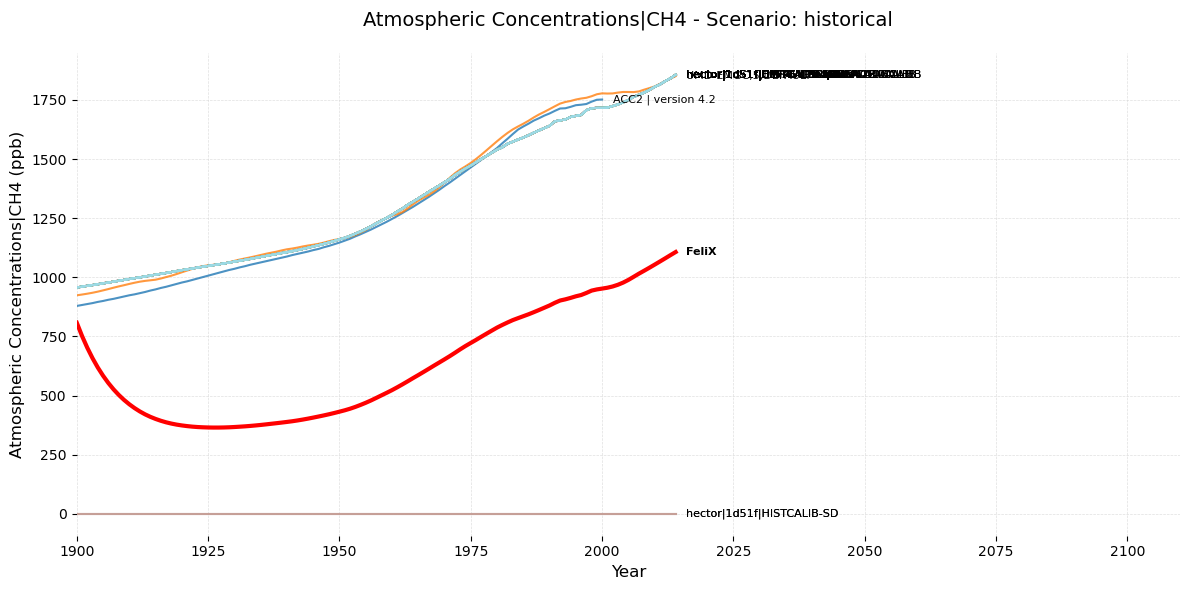

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (10, 757)
After region filtering: (10, 757)
After year range filtering: (10, 206)


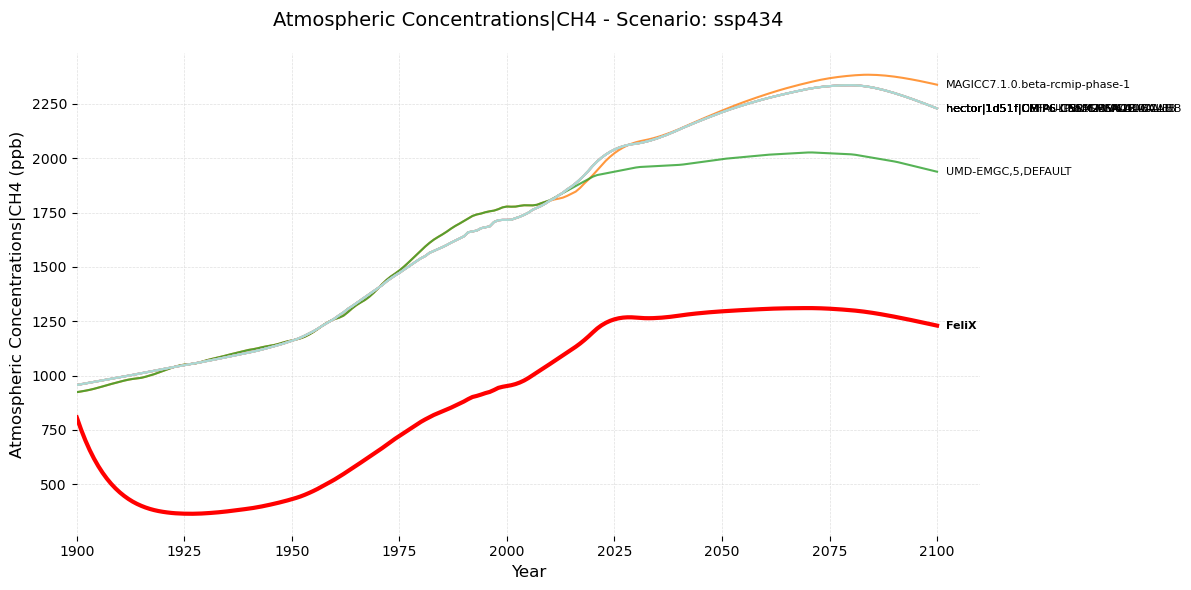

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (10, 757)
After region filtering: (10, 757)
After year range filtering: (10, 206)


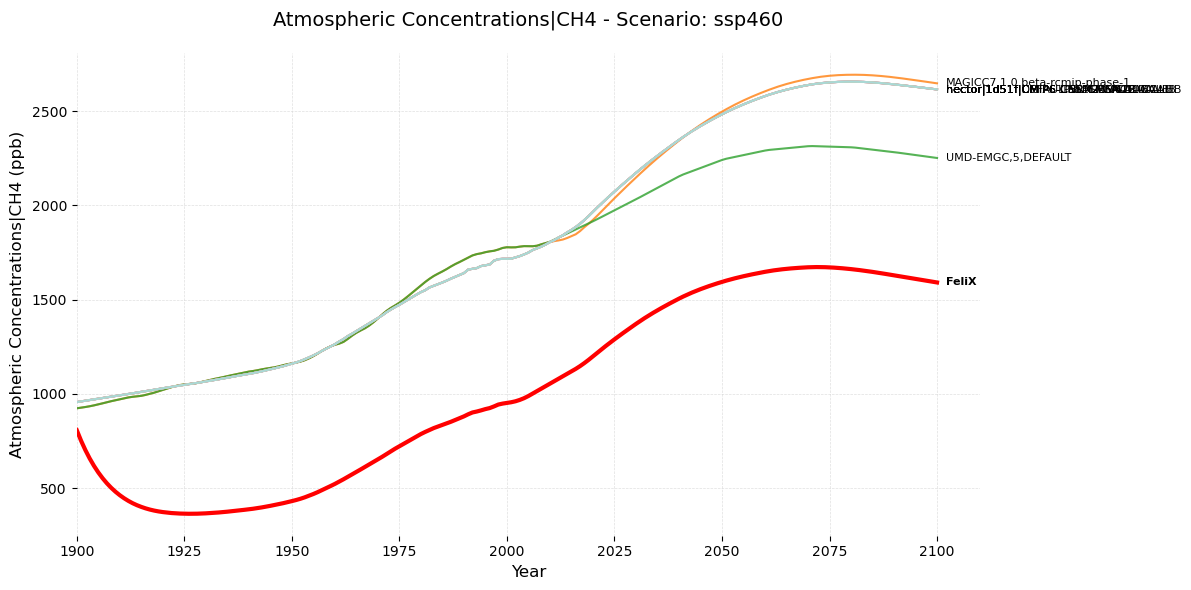

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (20, 757)
After region filtering: (20, 757)
After year range filtering: (20, 206)


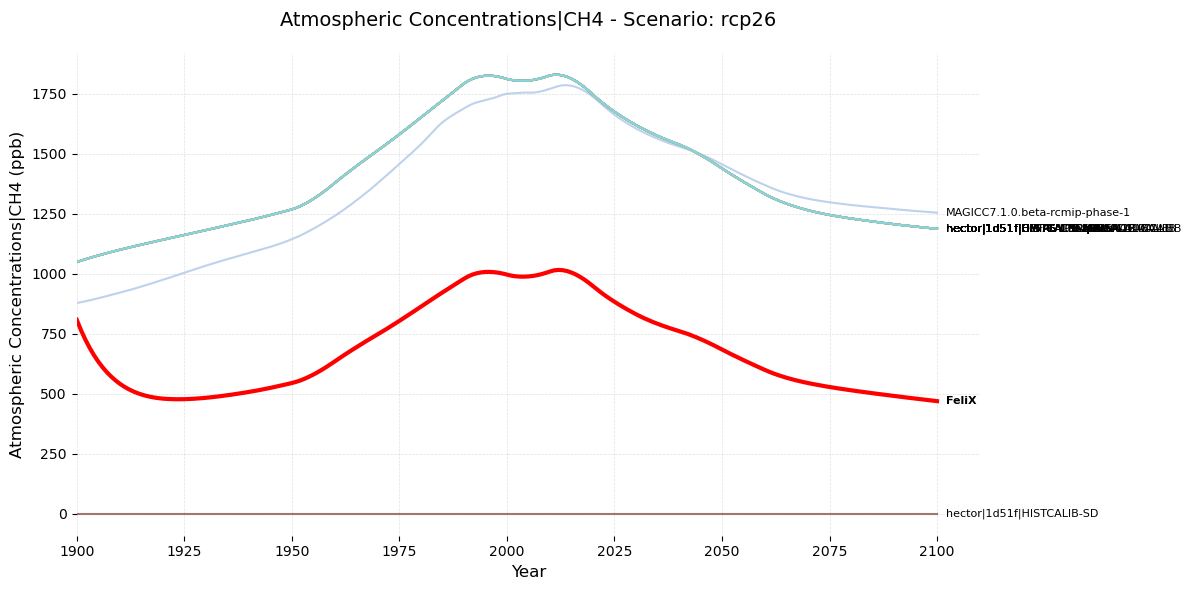

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (21, 757)
After region filtering: (21, 757)
After year range filtering: (21, 206)


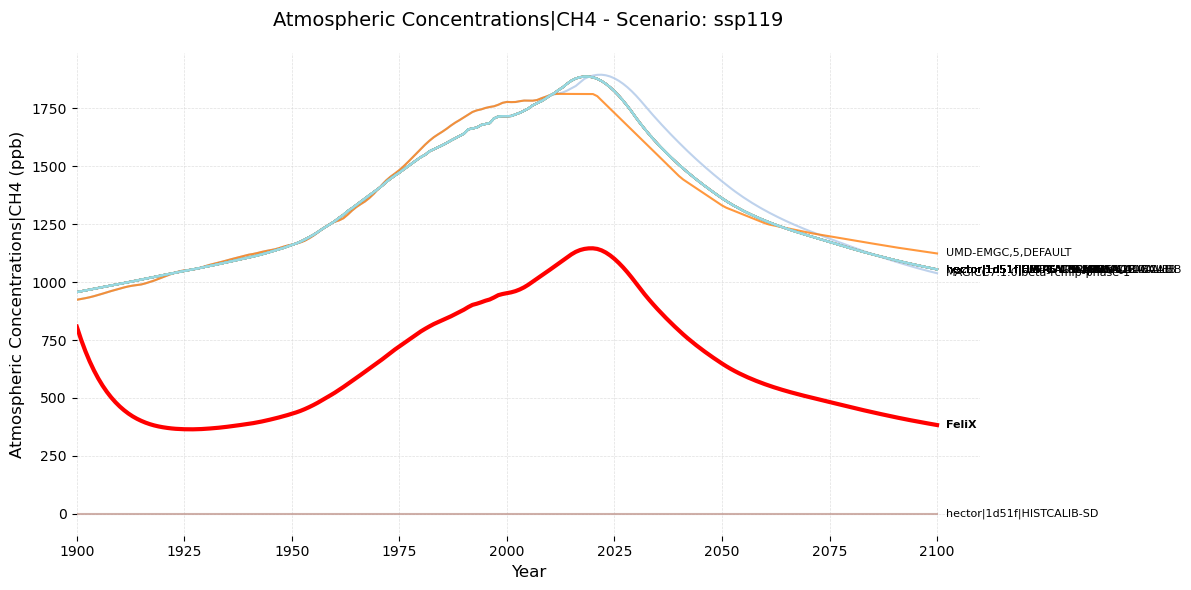

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (10, 757)
After region filtering: (10, 757)
After year range filtering: (10, 206)


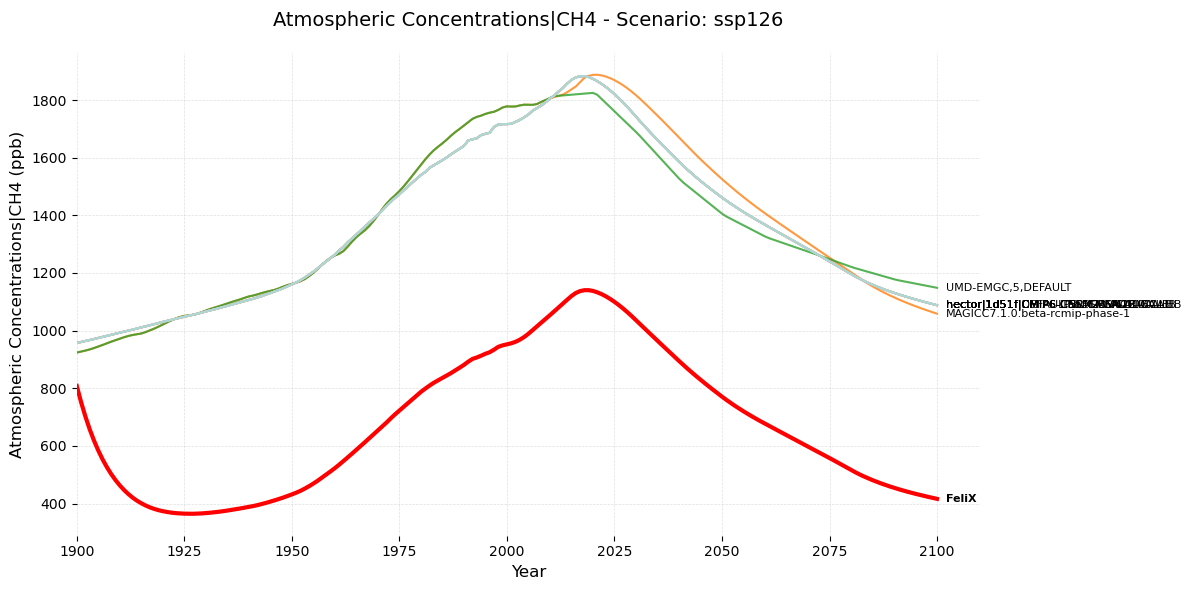

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (20, 757)
After region filtering: (20, 757)
After year range filtering: (20, 206)


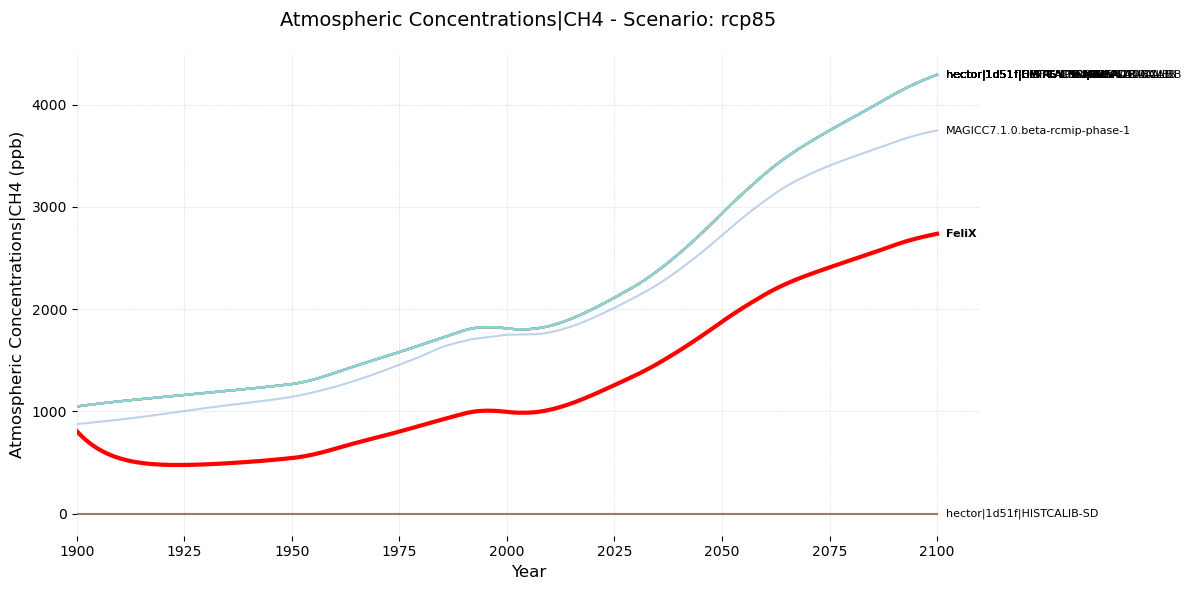

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (10, 757)
After region filtering: (10, 757)
After year range filtering: (10, 206)


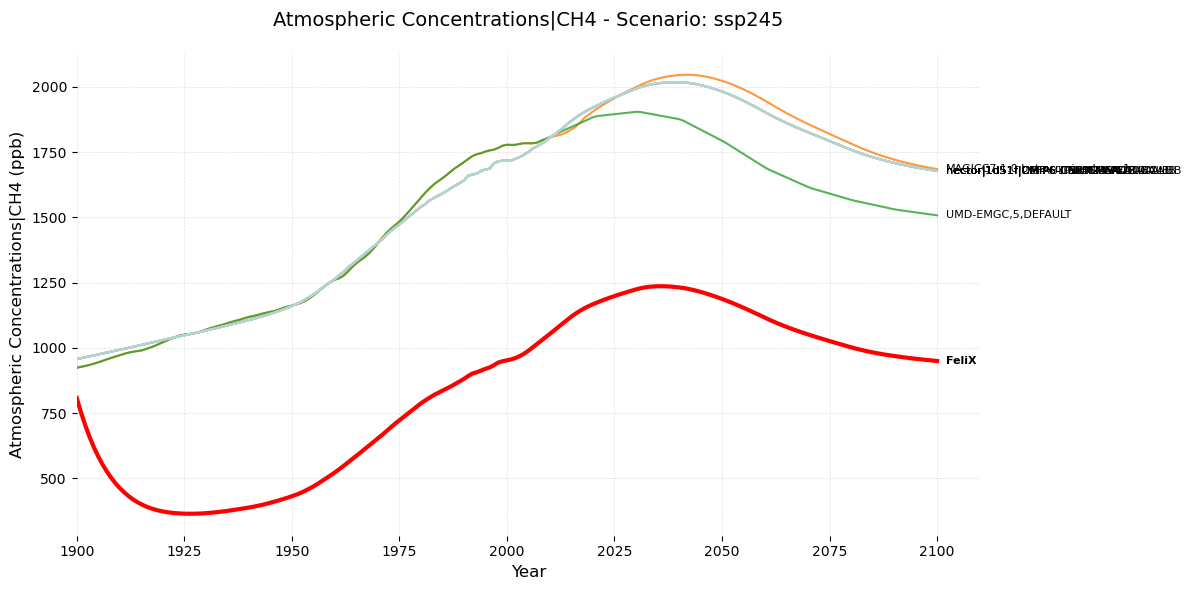

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (20, 757)
After region filtering: (20, 757)
After year range filtering: (20, 206)


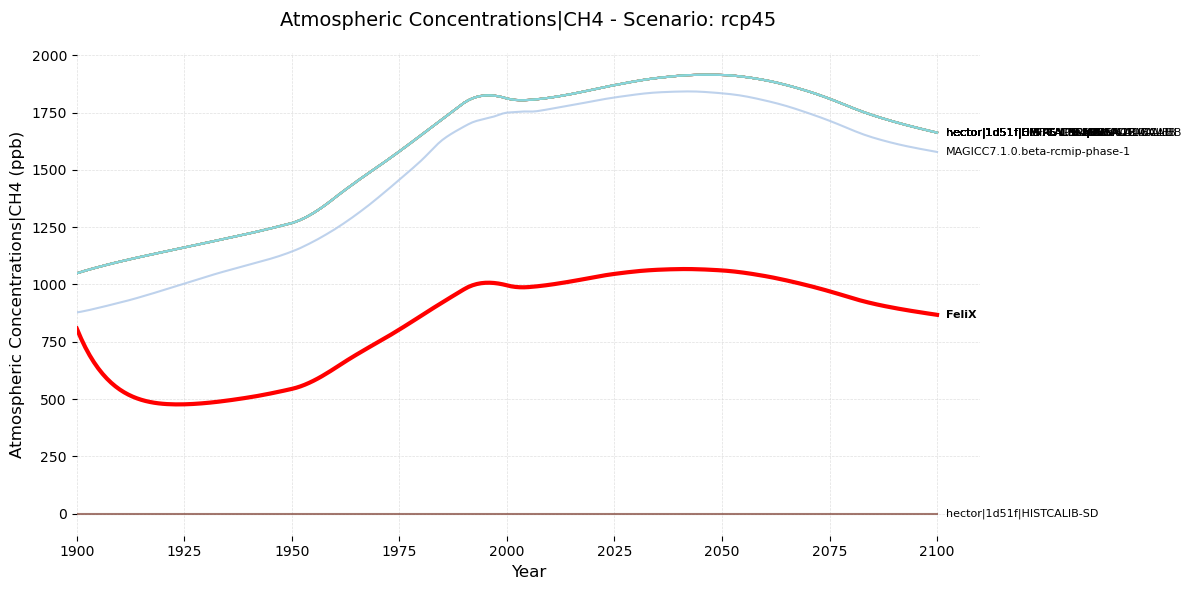

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


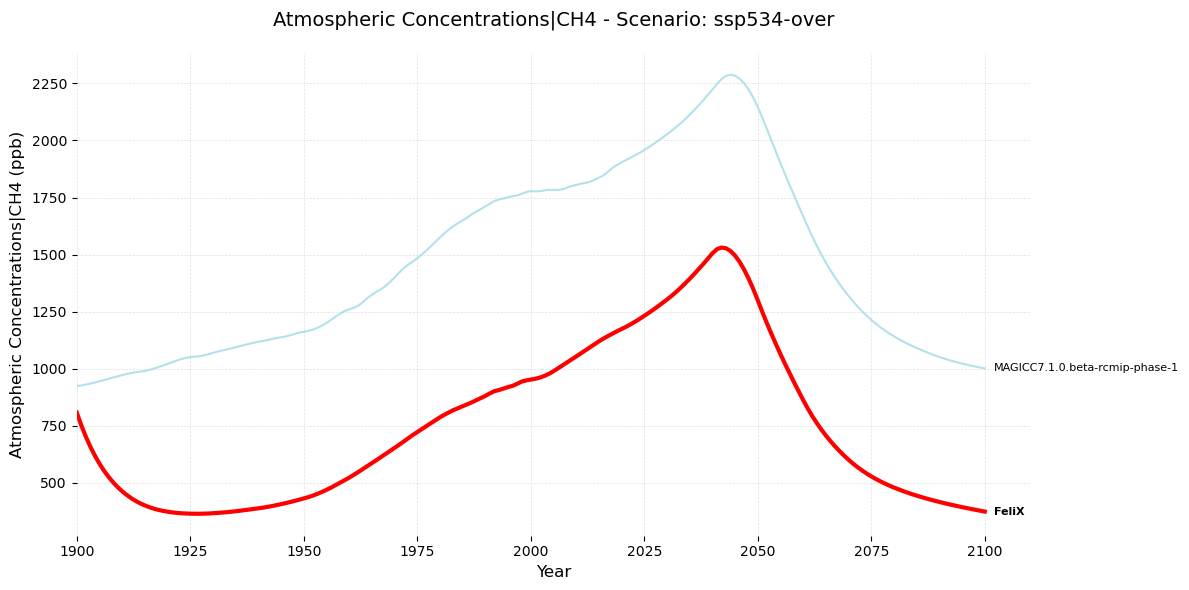

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (21, 757)
After region filtering: (21, 757)
After year range filtering: (21, 206)


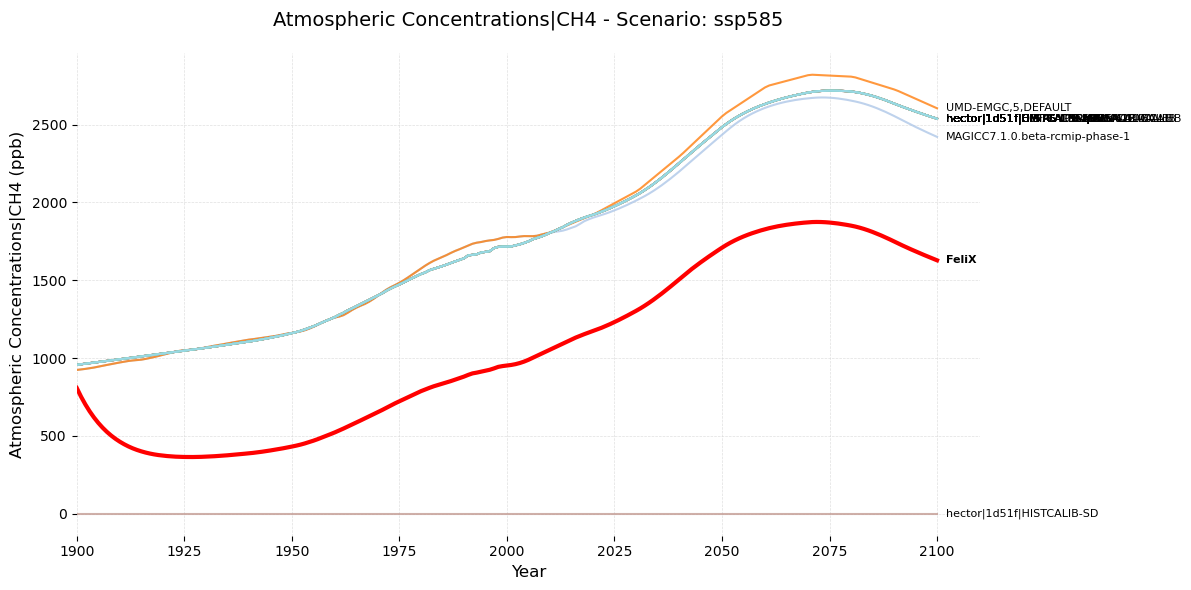

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


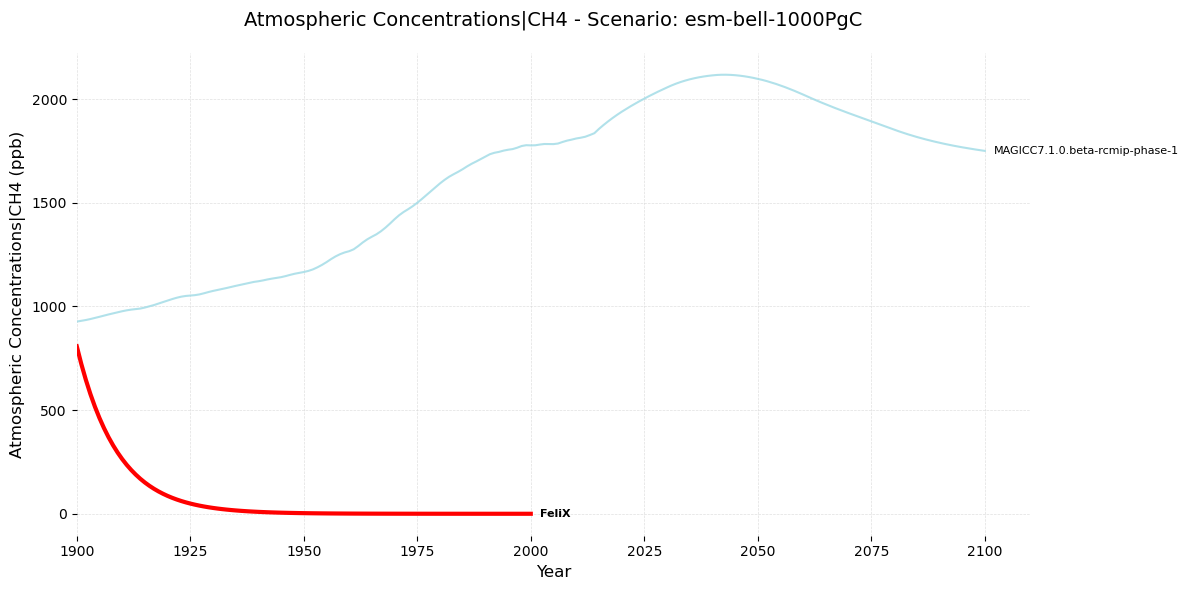

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


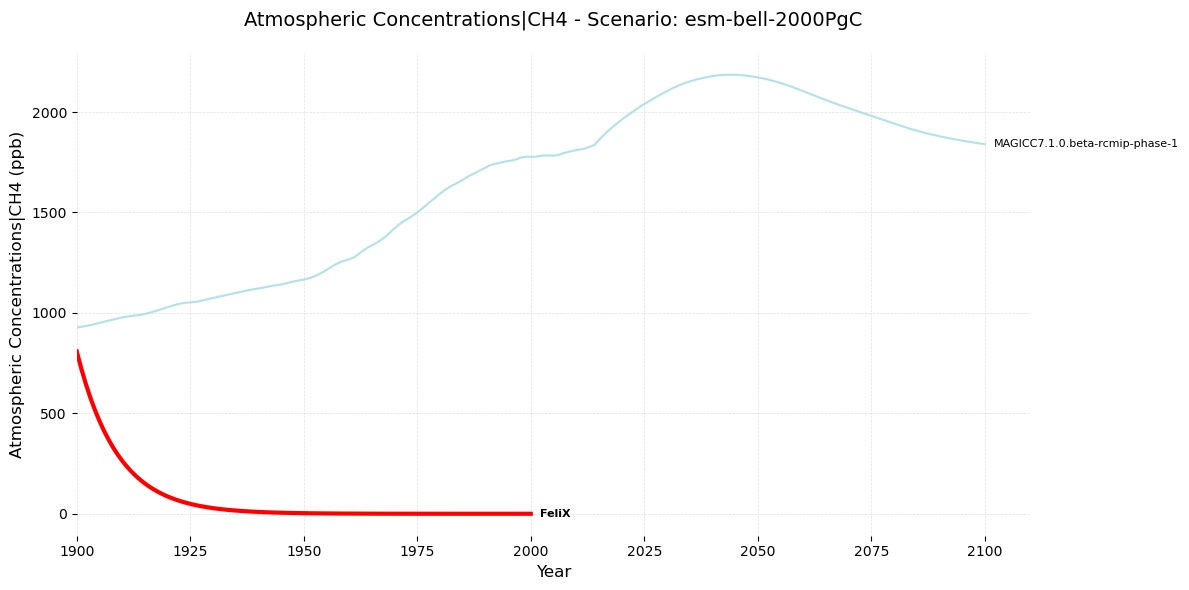

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


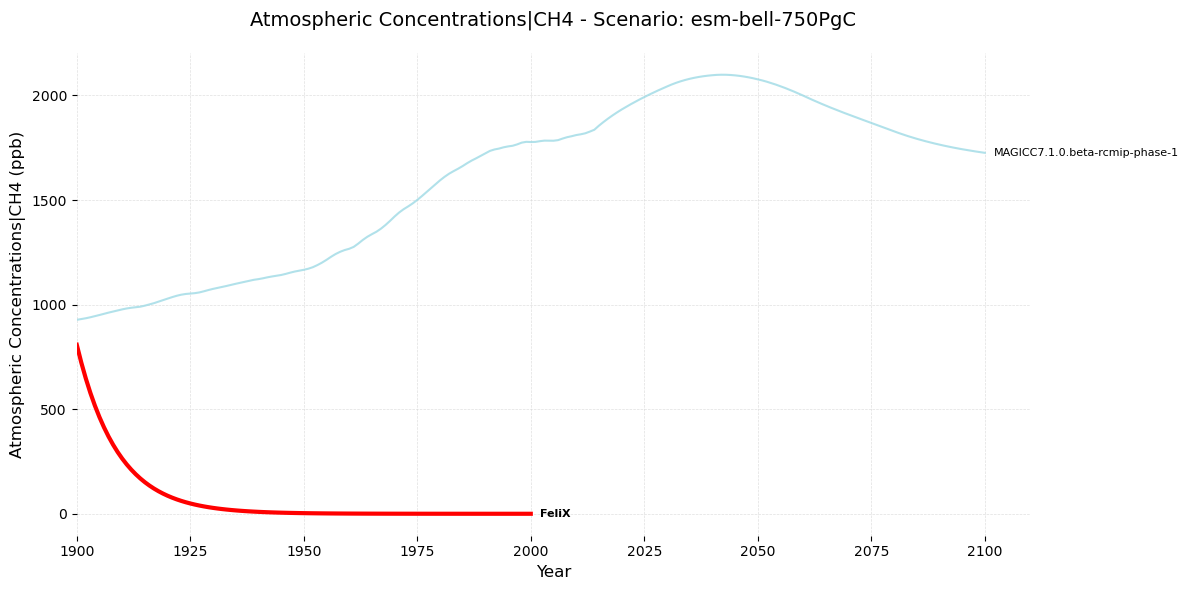

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


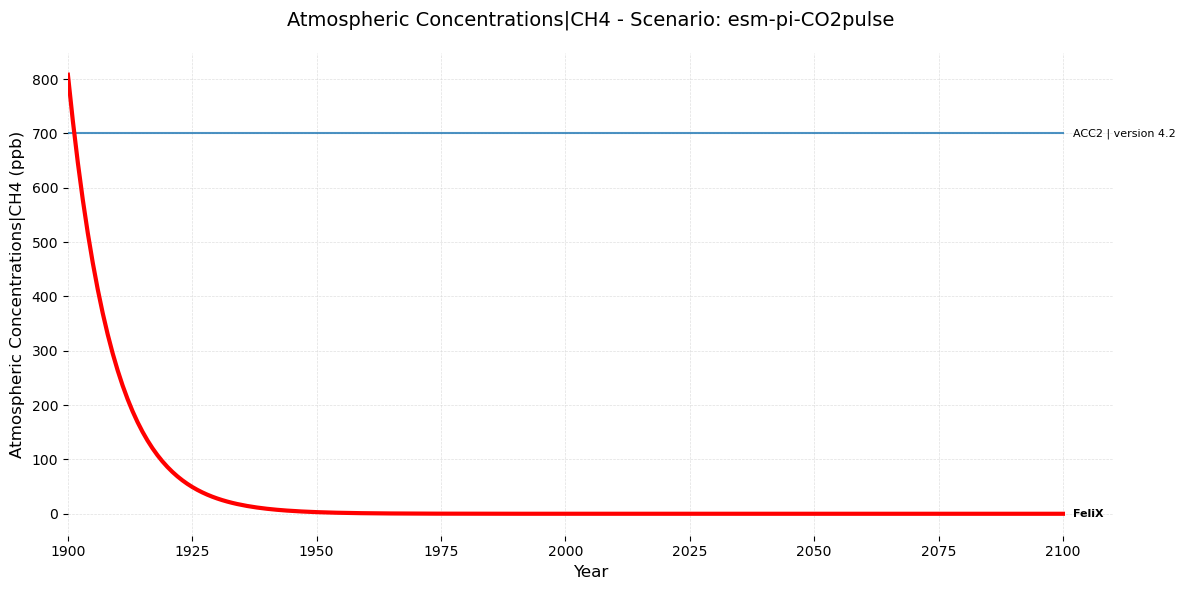

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


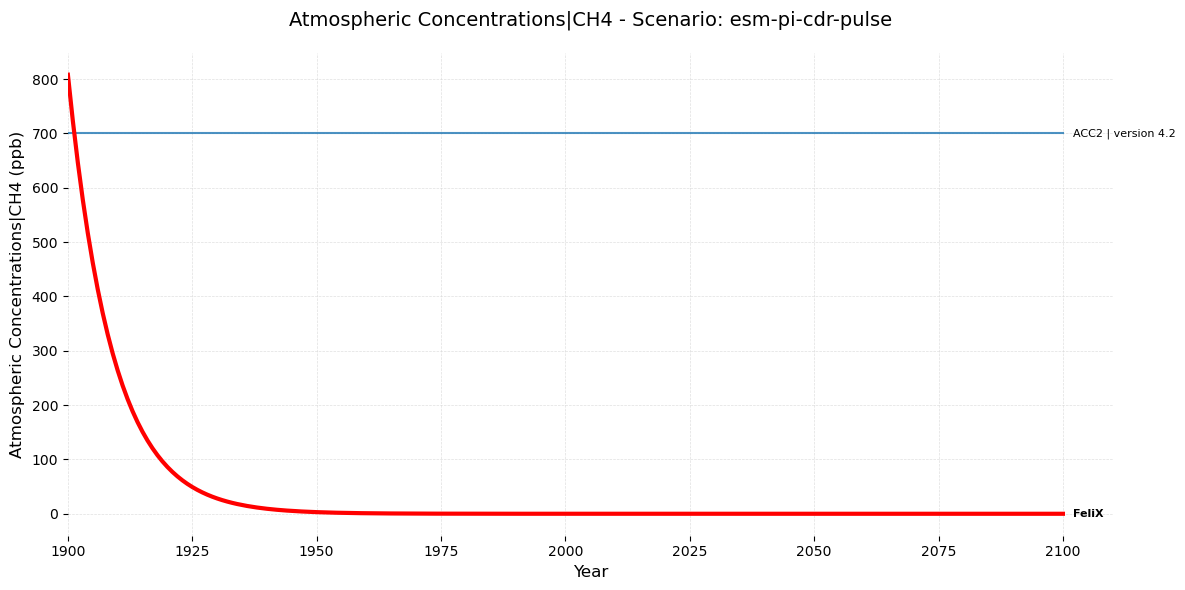

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (21, 757)
After region filtering: (21, 757)
After year range filtering: (21, 206)


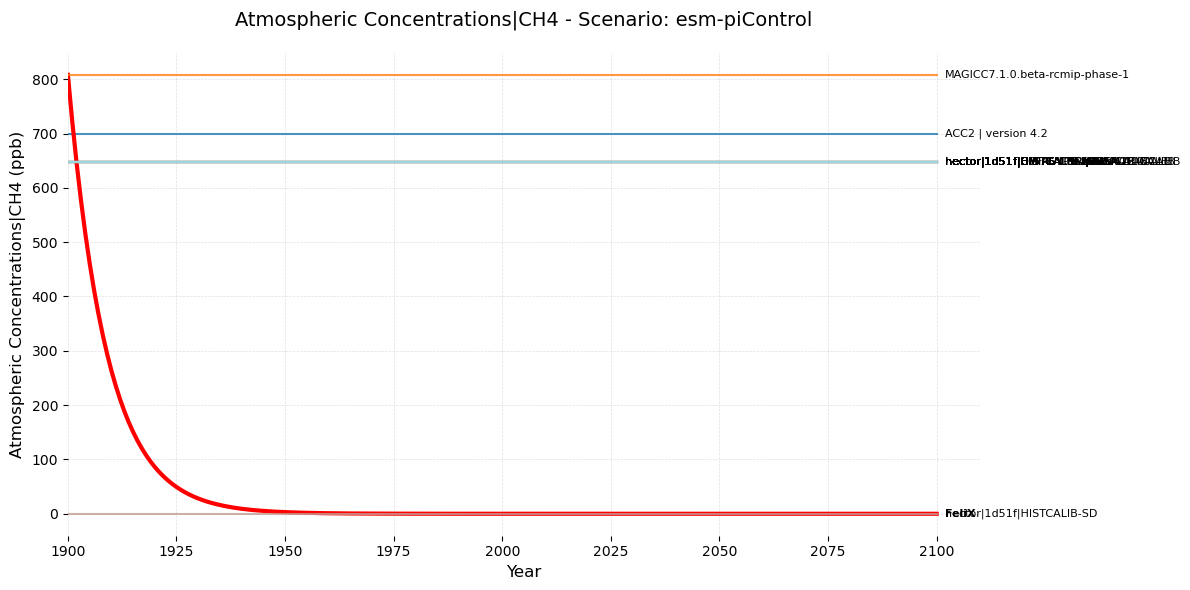

Original data shape: (23576, 757)
After variable filtering: (439, 757)
After scenario filtering: (19, 757)
After region filtering: (19, 757)
After year range filtering: (19, 206)


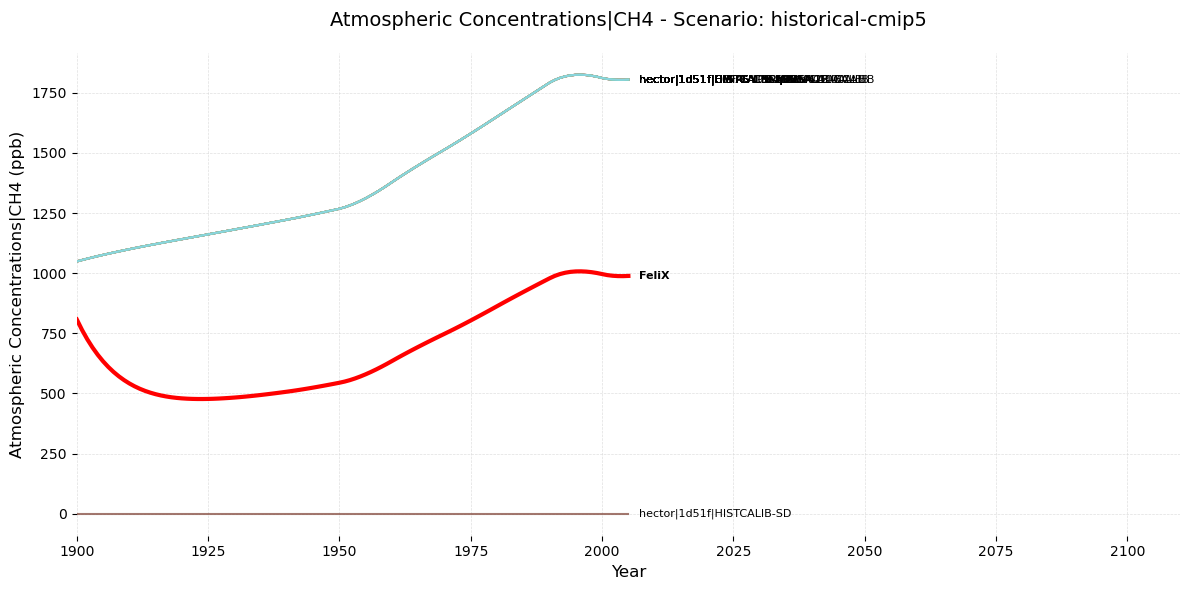

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (20, 757)
After region filtering: (20, 757)
After year range filtering: (20, 206)


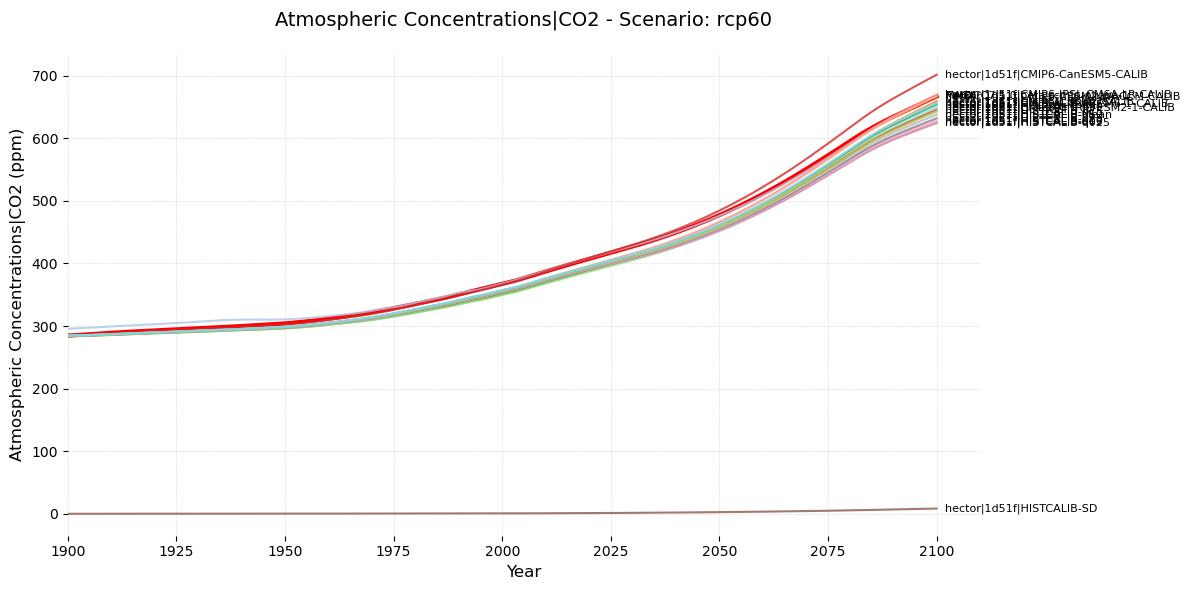

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (19, 757)
After region filtering: (19, 757)
After year range filtering: (19, 206)


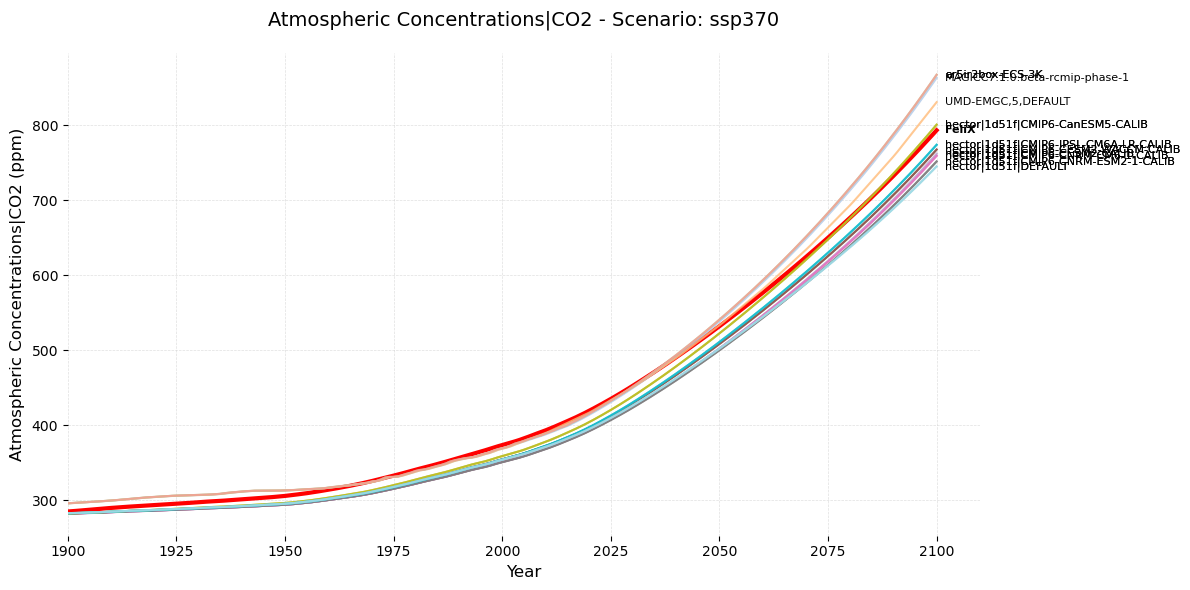

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


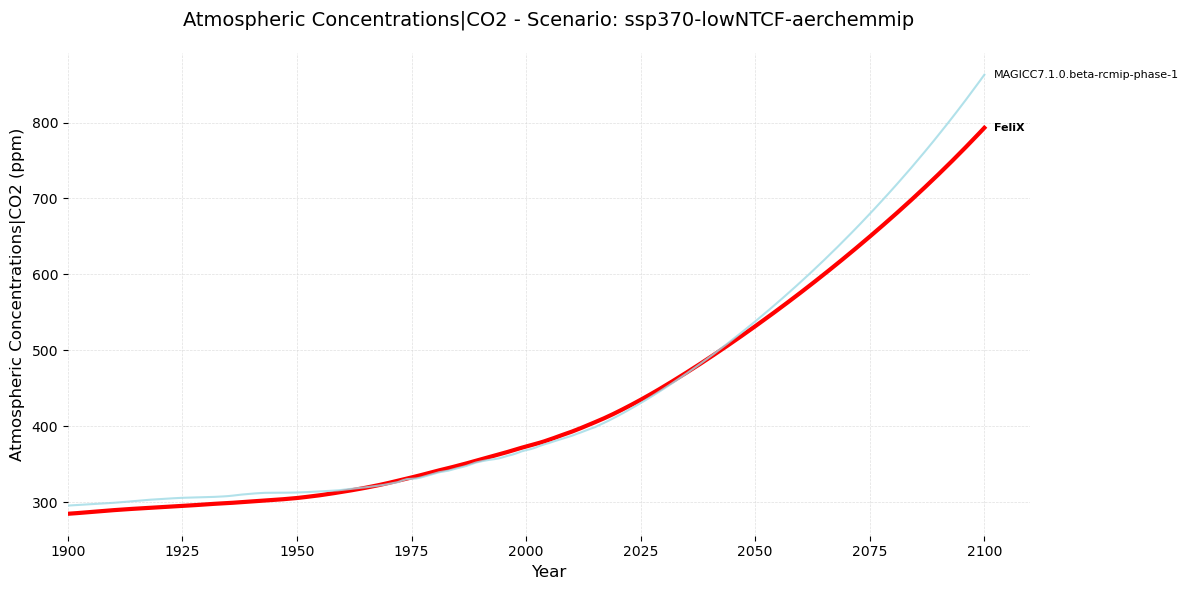

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


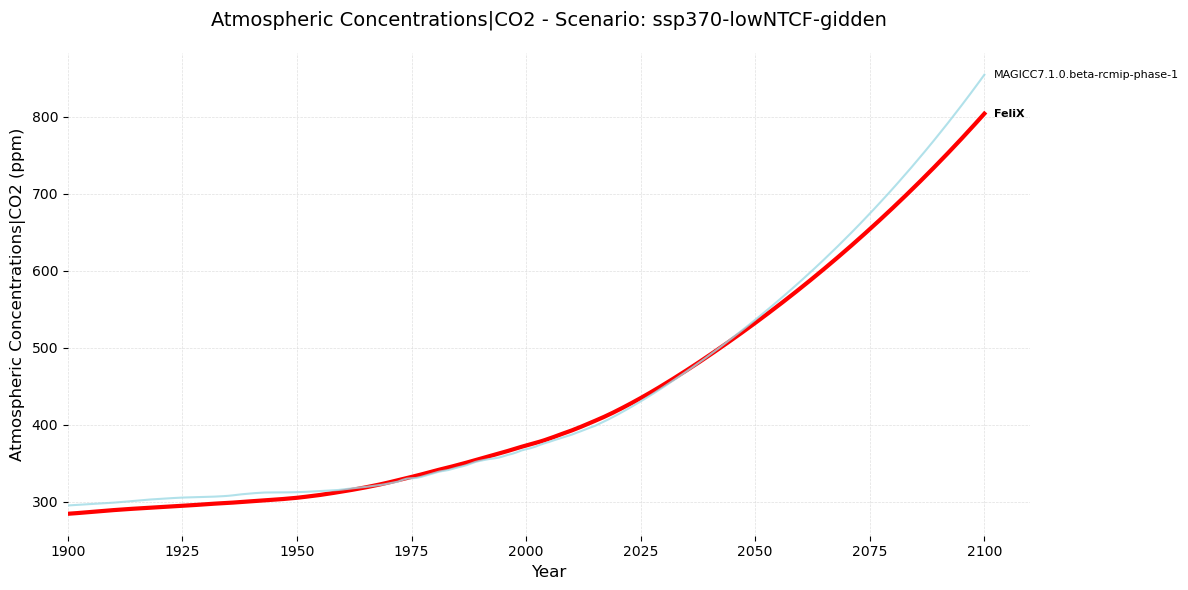

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (41, 757)
After region filtering: (41, 757)
After year range filtering: (41, 206)


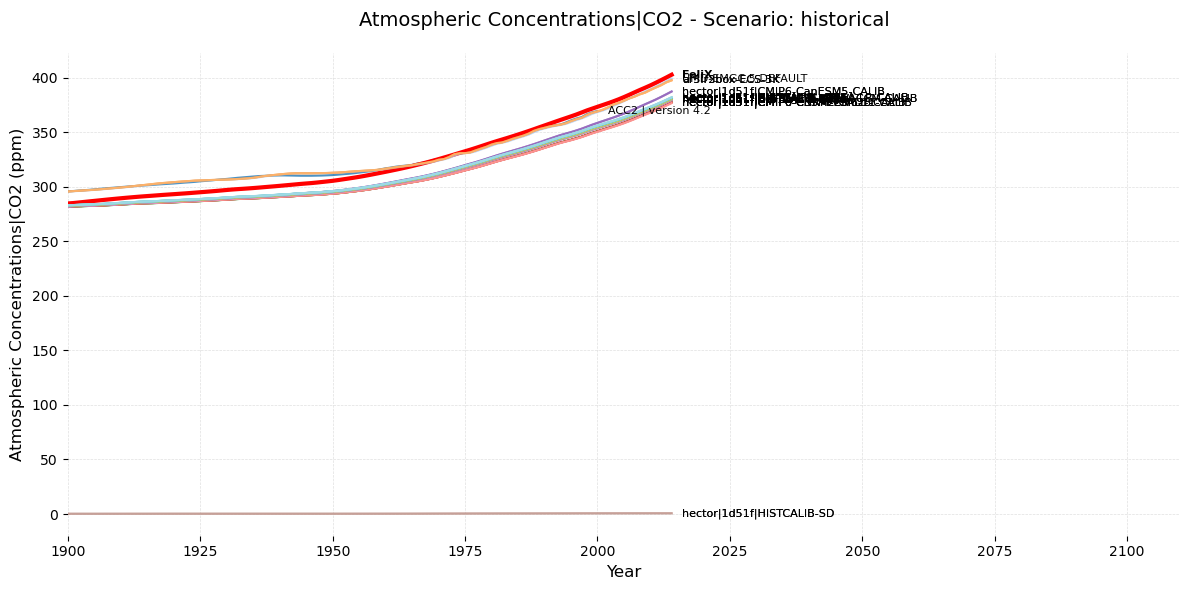

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (12, 757)
After region filtering: (12, 757)
After year range filtering: (12, 206)


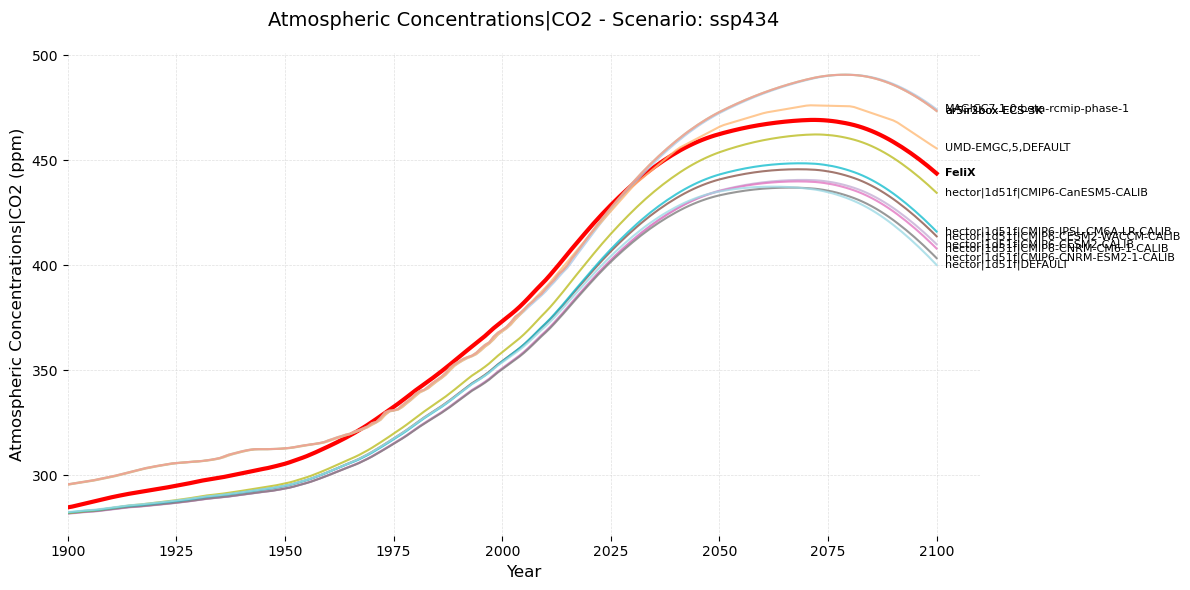

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (12, 757)
After region filtering: (12, 757)
After year range filtering: (12, 206)


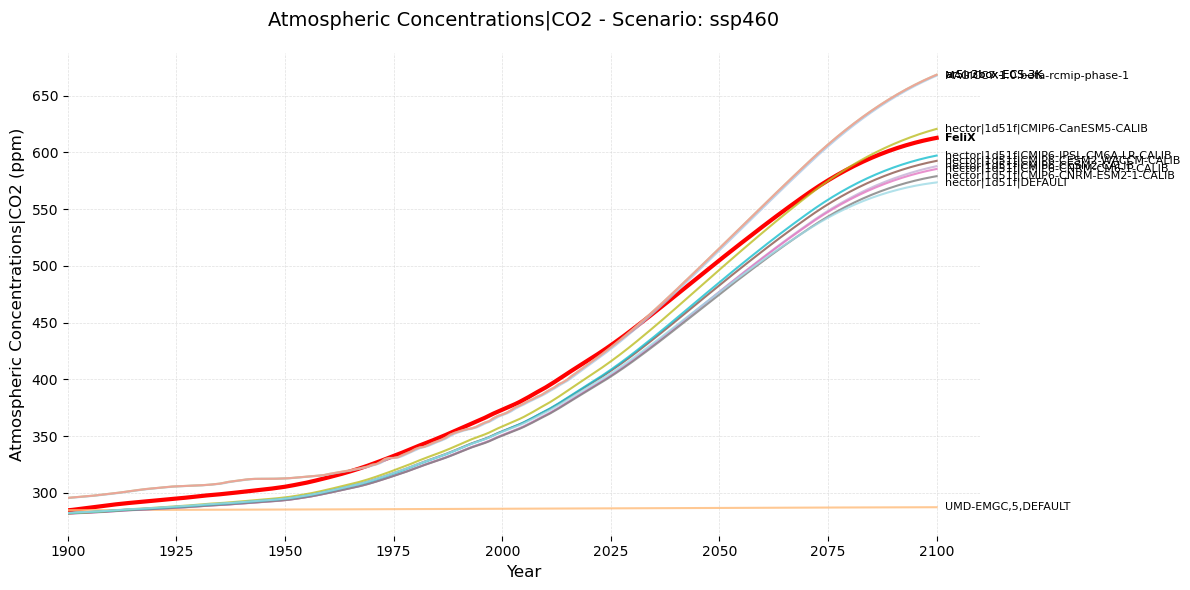

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (20, 757)
After region filtering: (20, 757)
After year range filtering: (20, 206)


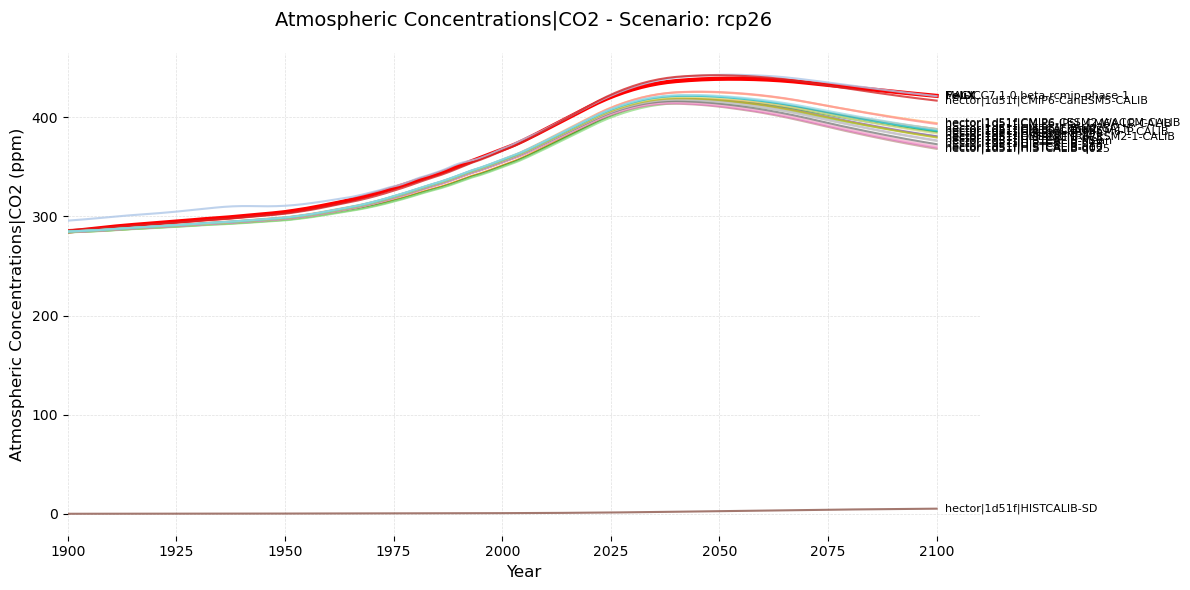

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (23, 757)
After region filtering: (23, 757)
After year range filtering: (23, 206)


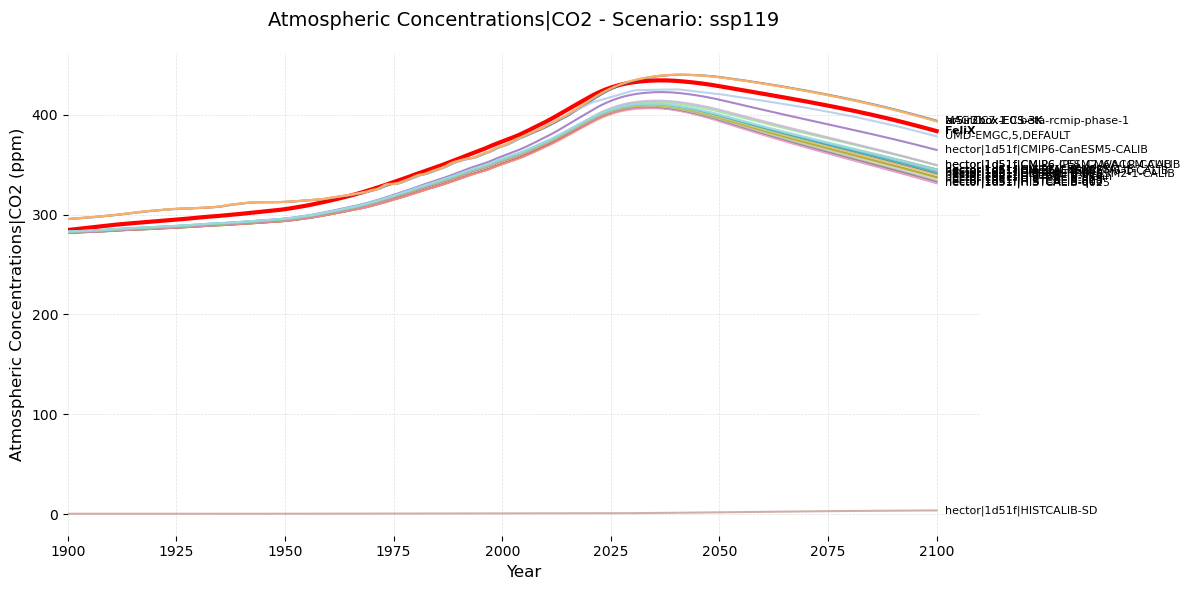

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (12, 757)
After region filtering: (12, 757)
After year range filtering: (12, 206)


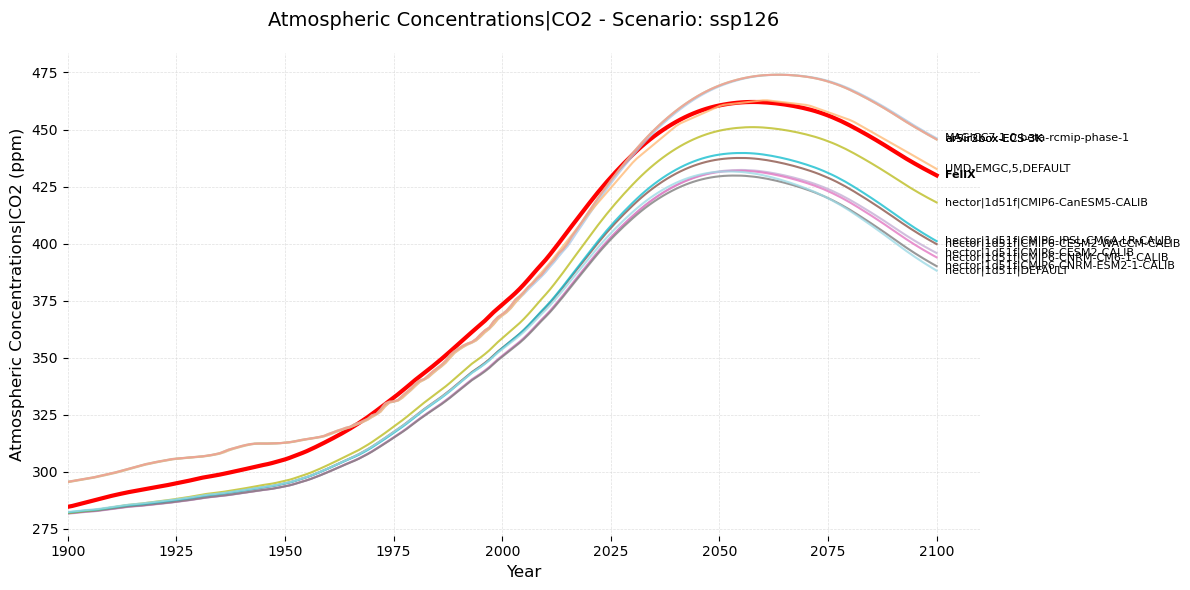

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (20, 757)
After region filtering: (20, 757)
After year range filtering: (20, 206)


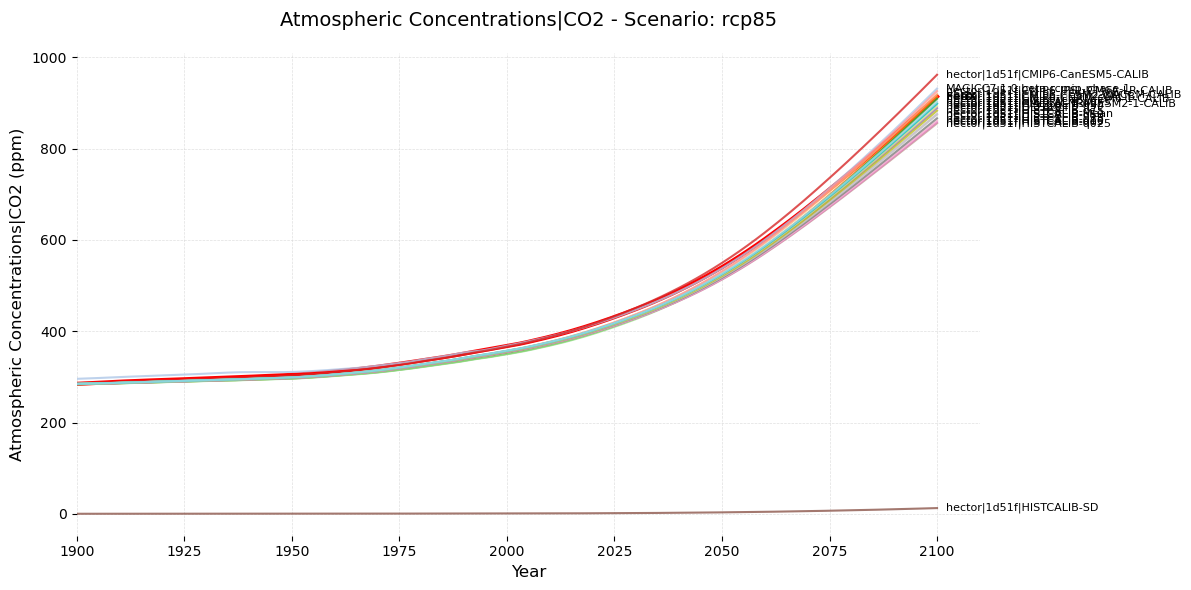

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (12, 757)
After region filtering: (12, 757)
After year range filtering: (12, 206)


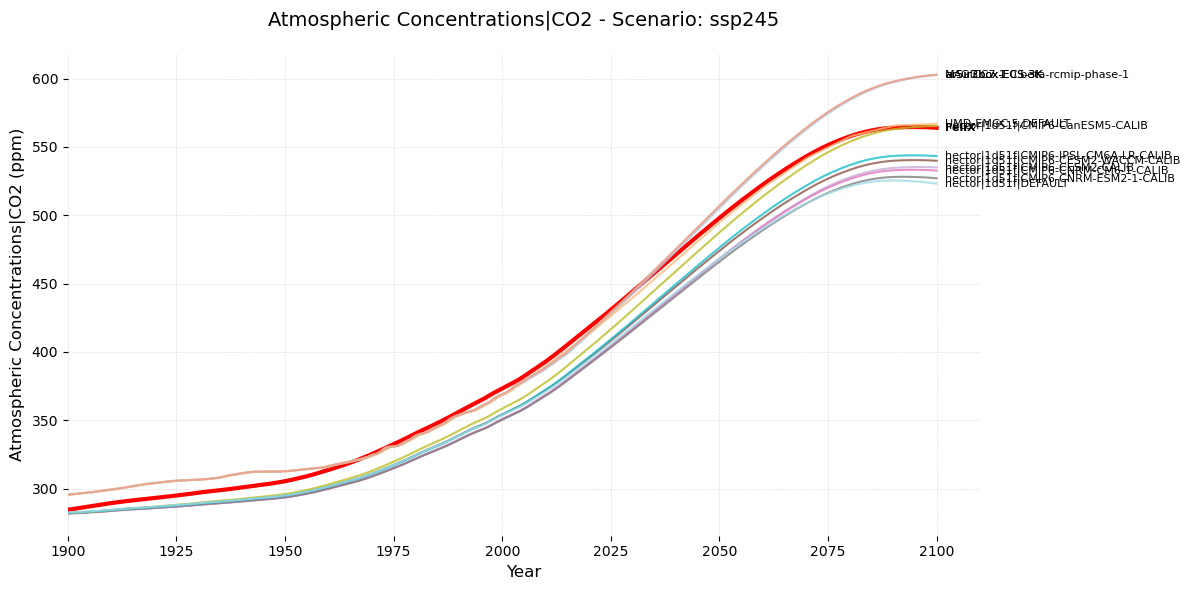

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (20, 757)
After region filtering: (20, 757)
After year range filtering: (20, 206)


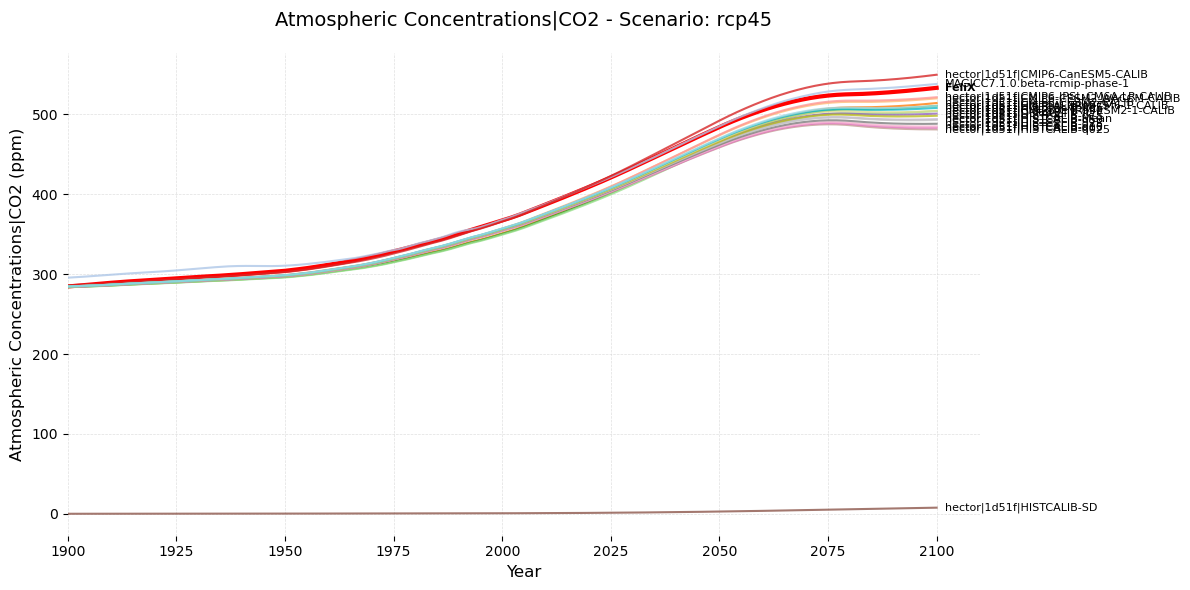

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (4, 757)
After region filtering: (4, 757)
After year range filtering: (4, 206)


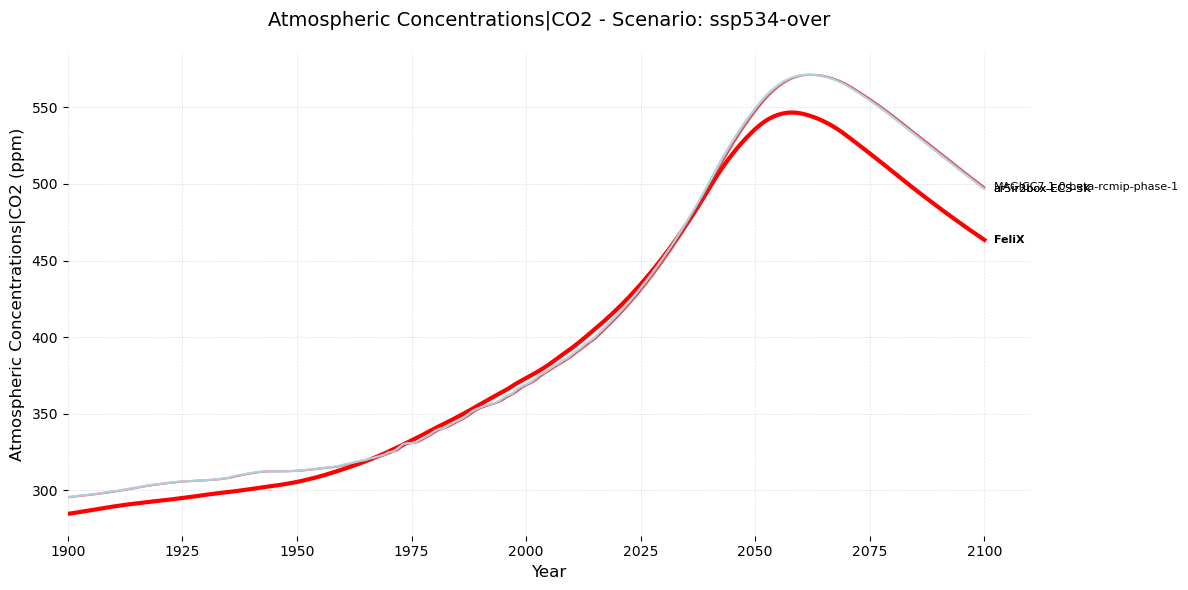

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (23, 757)
After region filtering: (23, 757)
After year range filtering: (23, 206)


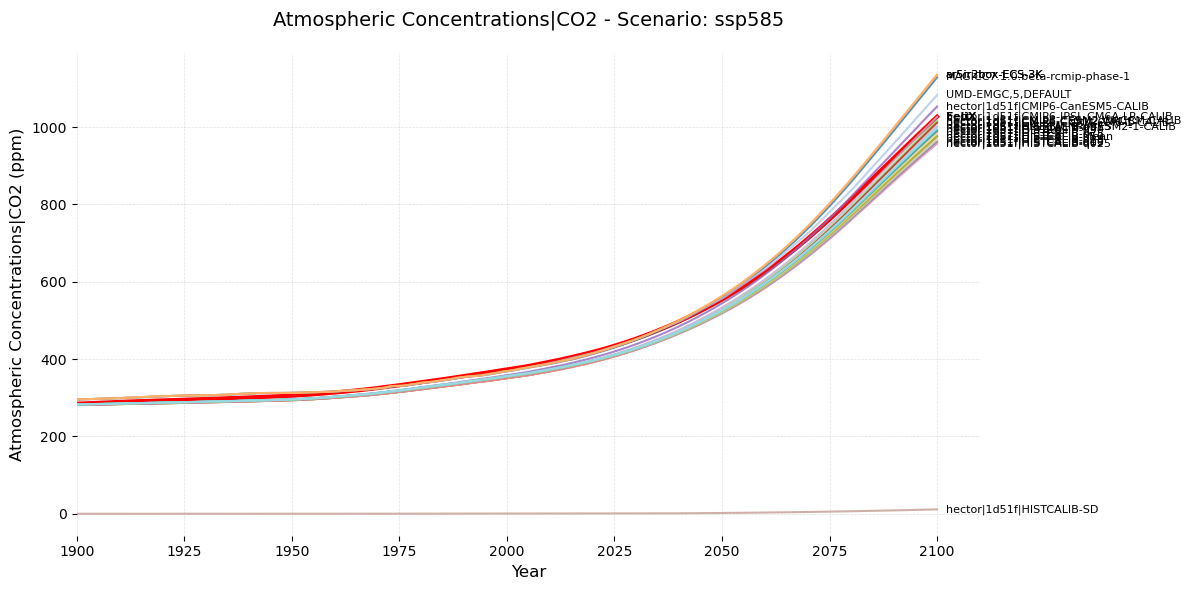

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


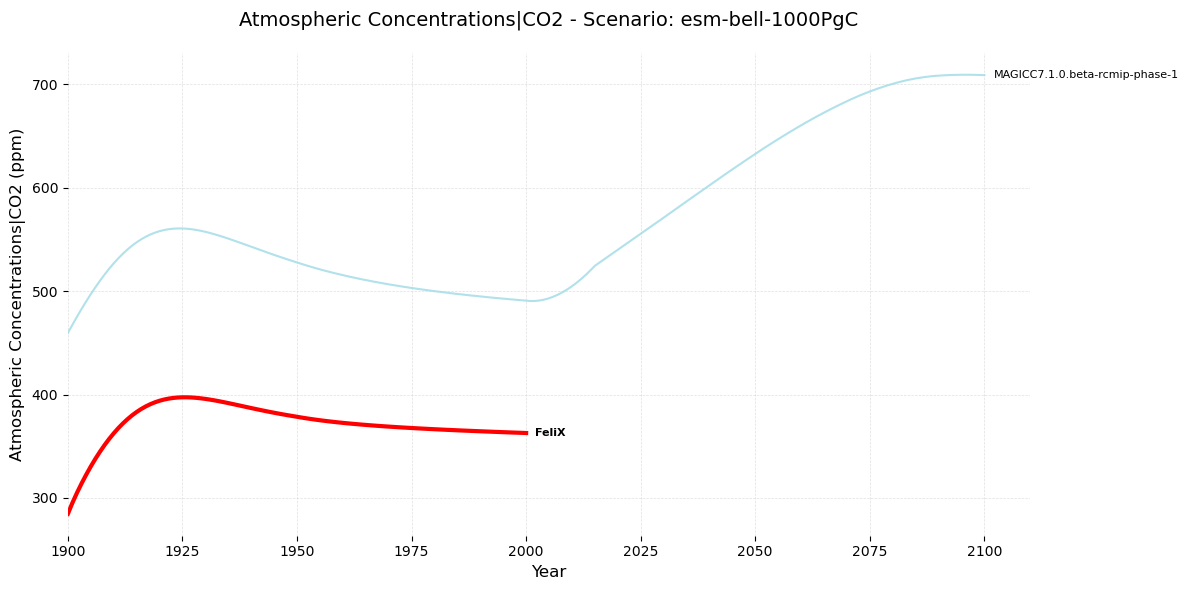

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


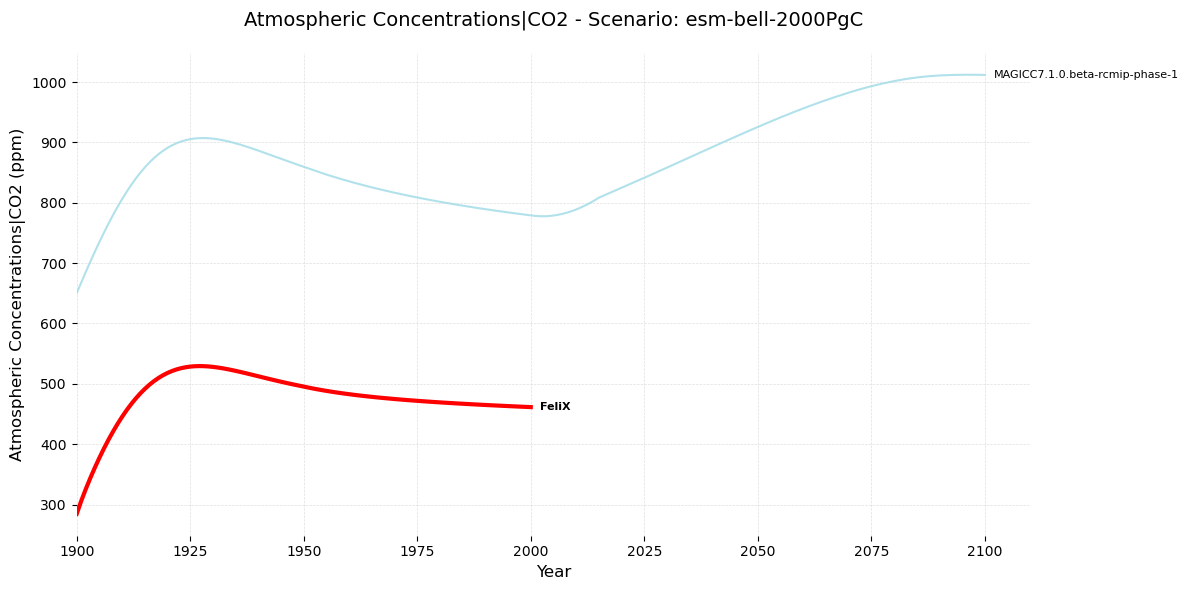

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


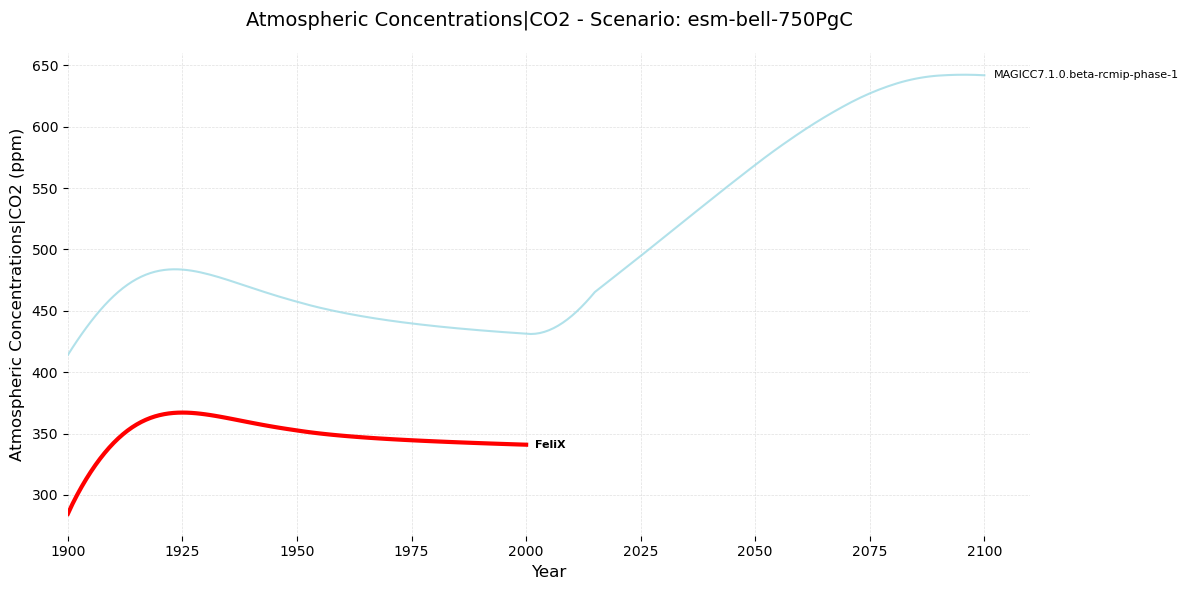

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


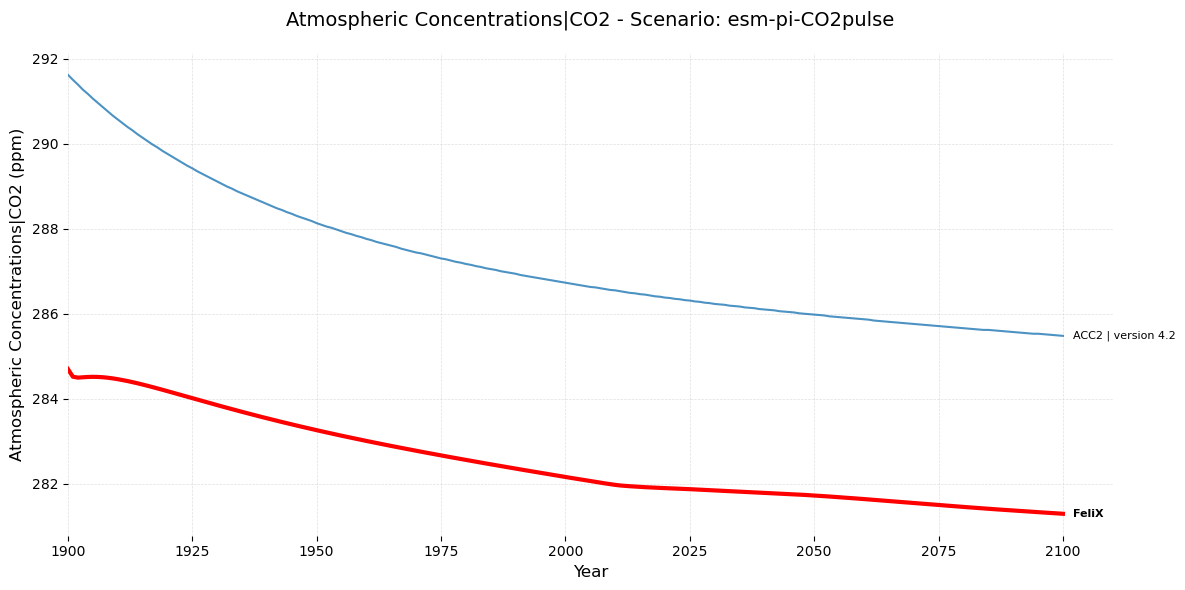

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (2, 757)
After region filtering: (2, 757)
After year range filtering: (2, 206)


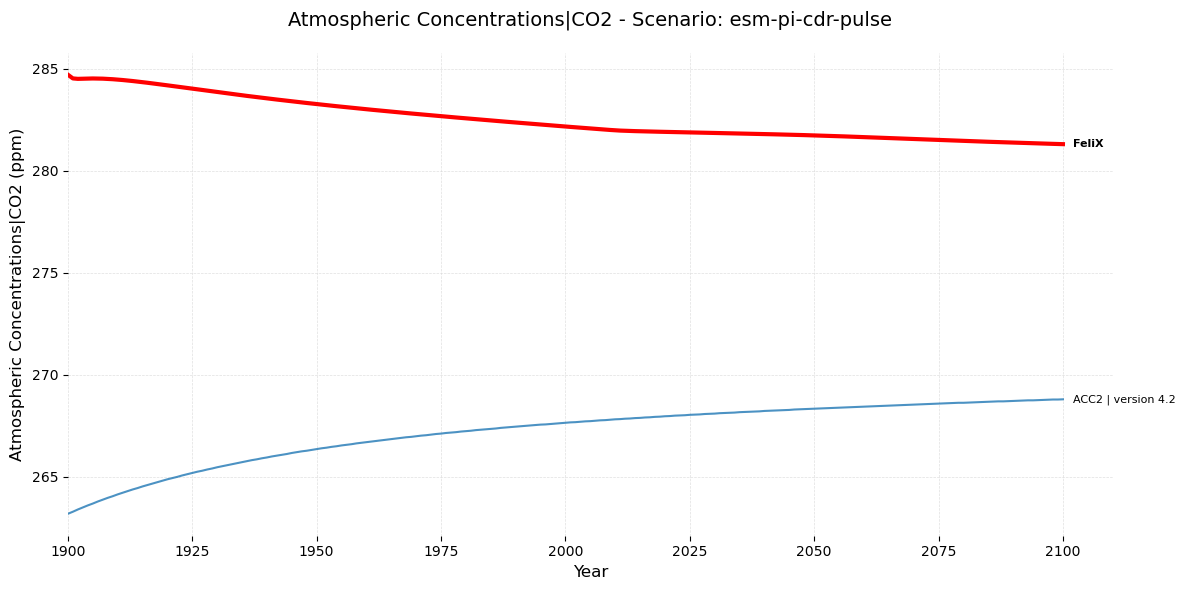

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (21, 757)
After region filtering: (21, 757)
After year range filtering: (21, 206)


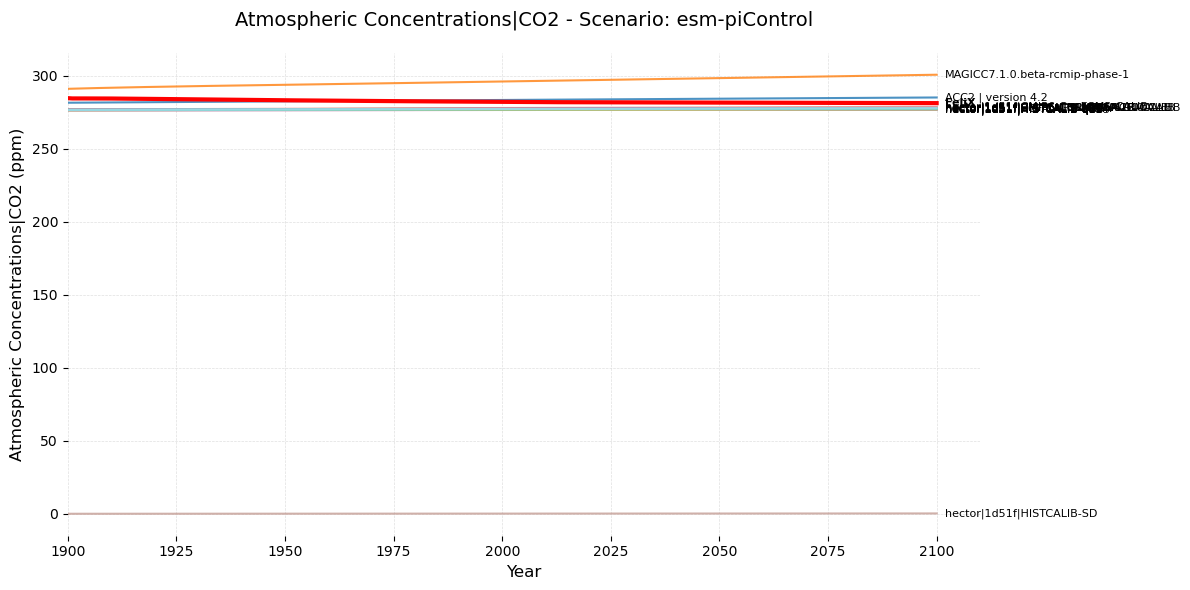

Original data shape: (23576, 757)
After variable filtering: (716, 757)
After scenario filtering: (19, 757)
After region filtering: (19, 757)
After year range filtering: (19, 206)


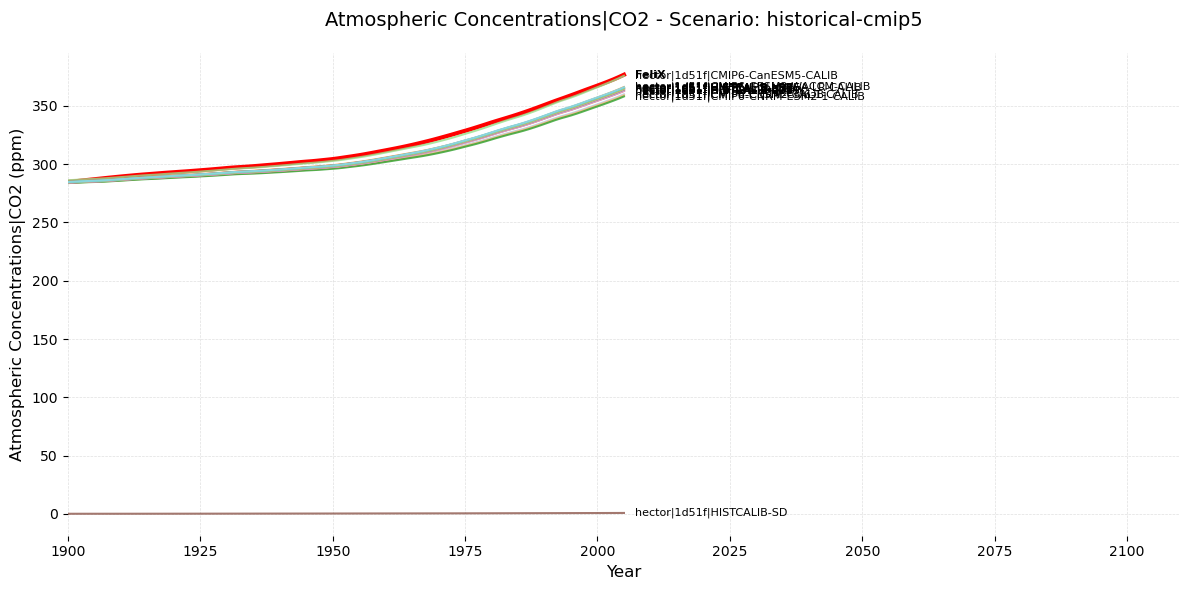

In [155]:
# CHOOSING SCENARIOS
unique_scenarios = merged_data[merged_data['ClimateModel'] == 'FeliX']['Scenario'].unique()


# CO2 Conc
variable_name = "Atmospheric Concentrations|N2O"
for scenario in unique_scenarios:
    fig, df = visualize_rcmip_data(merged_data,
                                   variables=[variable_name],
                                   scenarios= scenario,
                                   region= "World",
                                   year_range=(1900, 2100),
                                   compare_by='ClimateModel',
                                   plot_title=f"{variable_name} - Scenario: {scenario}")
    fig.savefig(f"Figures/{variable_name.replace('|', '_')}_{scenario}.png")

# CH4 Conc
variable_name = "Atmospheric Concentrations|CH4"
for scenario in unique_scenarios:
    fig, df = visualize_rcmip_data(merged_data,
                                   variables=[variable_name],
                                   scenarios= scenario,
                                   region= "World",
                                   year_range=(1900, 2100),
                                   compare_by='ClimateModel',
                                   plot_title=f"{variable_name} - Scenario: {scenario}")
    fig.savefig(f"Figures/{variable_name.replace('|', '_')}_{scenario}.png")


# CO2 Conc
variable_name = "Atmospheric Concentrations|CO2"
for scenario in unique_scenarios:
    fig, df = visualize_rcmip_data(merged_data,
                                   variables=[variable_name],
                                   scenarios= scenario,
                                   region= "World",
                                   year_range=(1900, 2100),
                                   compare_by='ClimateModel',
                                   plot_title=f"{variable_name} - Scenario: {scenario}")
    fig.savefig(f"Figures/{variable_name.replace('|', '_')}_{scenario}.png")




## Preparing Visualization Functions

In [121]:
## Basically, the code should be like f(var = xxx; scenario = xxx; model_exclude= none)

In [122]:
# Create

# Visualizing Model Runs

In [123]:
## Code here

## Effective Radiative Forcing

In [124]:
## Code here

## Effective Climate Sensitivity

In [125]:
## Code here